# SPAN Benchmarks H3K4me3 vs RNA-seq

See https://pubmed.ncbi.nlm.nih.gov/27169896/

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import tempfile
from itertools import product


In [2]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file


def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Hg38 load peaks

In [3]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K4me3']
GSE26320_REPS = ['rep1', 'rep2']
# GSE26320_REPS = ['rep1']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [4]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((c for c in GSE26320_CELLS if c in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [5]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(2)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 16


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 16


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 16


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 16


file modification  cell  \
14  /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3  NHLF   
3   /home/jetbrains/data/2023_GSE26320/macs2/GSM64...      H3K4me3  HMEC   

   replicate   fdr  peaks     avlength   tool  
14      rep2  0.05  31110  1037.100032  MACS2  
3       rep1  0.05  26661   800.795056  MACS2

In [6]:
# TOOLS_PALETTE = {'MACS2': 'blue', 'MACS2 broad': 'orange', 'SICER': 'green', 'SPAN': 'red', 'Genes': 'brown'}
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER', 'Genes']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

## Peaks number

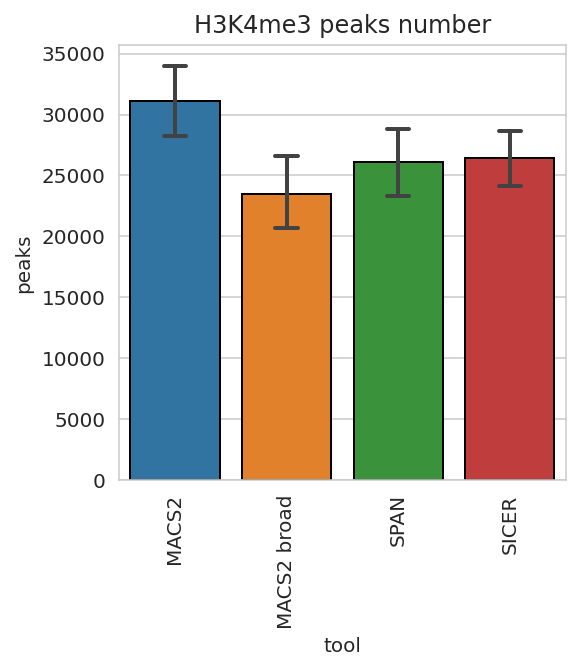

In [7]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='tool', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K4me3 peaks number')
plt.show()

In [8]:
print('Load lengths')
ts = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    lengths = bedl(file)
    t = pd.DataFrame(dict(tool=[tool] * len(lengths), length=lengths))
    ts.append(t.sample(min(len(t), 10_000)))
t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

tool  length
232735  MACS2 broad     996
80591         MACS2     884
491409         SPAN     570
104767        MACS2    1144
587857         SPAN    1358
114609        MACS2     250
212024  MACS2 broad     365
470673        SICER     999
456582        SICER    2199
225754  MACS2 broad     802

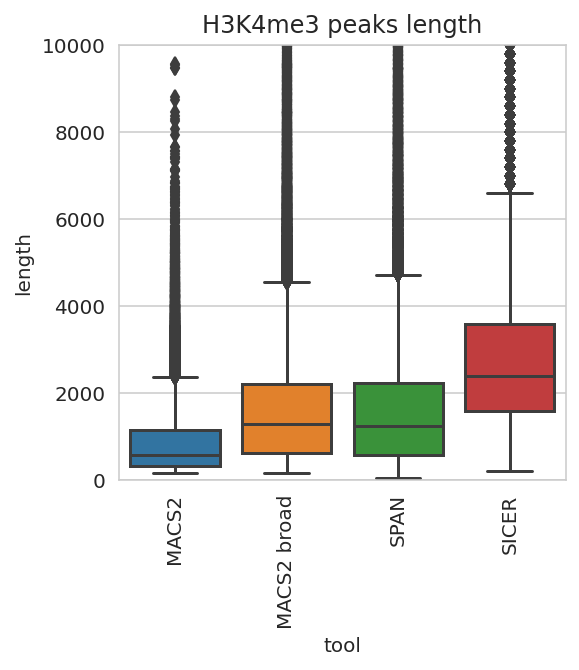

In [9]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='tool', y='length', ax=ax, order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.title.set_text('H3K4me3 peaks length')
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylim([0, 10_000])
plt.show()

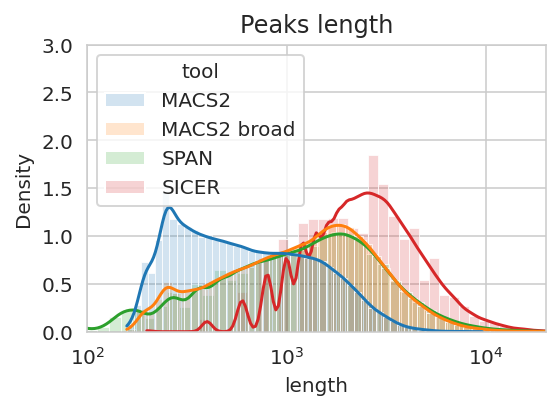

In [10]:
plt.figure(figsize=(4, 3))
ax = plt.axes()
g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         palette=TOOLS_PALETTE,
                         hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
g_results.set(xscale='log')
g_results.set_ylim(0, 3)
g_results.set_xlim(1e2, 2e4)
ax.title.set_text('Peaks length')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_lengths.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [11]:
# # Randomly tweak SPAN,SICER lengths for visualization purposes
# tspan = t['tool'] == 'SPAN'
# t.loc[tspan, 'length'] += np.random.normal(0, 100, size=sum(tspan))
# tsicer = t['tool'] == 'SICER'
# t.loc[tsicer, 'length'] += np.random.normal(0, 100, size=sum(tsicer))

In [12]:
# plt.figure(figsize=(6, 4))
# ax = plt.axes()
# g_results = sns.histplot(data=t, x='length', hue='tool', ax=ax,
#                          stat='density', common_bins=False, common_norm=False,
#                          kde=True, log_scale=True, alpha=0.2,
#                          palette=TOOLS_PALETTE)
# g_results.set(xscale='log')
# g_results.set_ylim(0, 3)
# g_results.set_xlim(1e2, 2e4)
# ax.title.set_text('H3K4me3 peaks length')
# plt.show()

In [13]:
t = []
for file, tool in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['tool'])):
    coverage = bedl(file).sum()
    t.append((tool, coverage))
t = pd.DataFrame(data=t, columns=['tool', 'coverage'])
t.sample(10)

0it [00:00, ?it/s]

tool  coverage
14        MACS2  32264182
10        MACS2  31458600
51         SPAN  28974012
20  MACS2 broad  57626660
38        SICER  80370548
9         MACS2  16943577
32        SICER  61486857
13        MACS2  30027786
17  MACS2 broad  42094658
58         SPAN  47813134

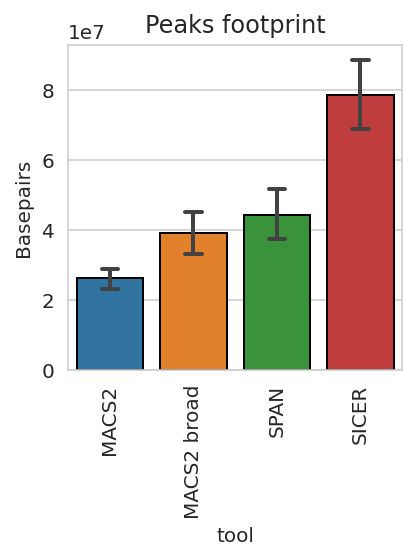

In [14]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
g_results = sns.barplot(data=t, x='tool', y='coverage', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('Peaks footprint')
ax.set_ylabel('Basepairs')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_sumlength.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Differences between narrow and broad peaks

In [15]:
! mkdir -p {GSE26320_PATH_HG38}/union

perc_ratio_df = pd.DataFrame(
    columns=['cell', 'replicate', 'length', 'tool', 'overlap_span_peaks', 'overlap_tool_peaks'],
    dtype=object
)

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['cell', 'replicate', 'length', 'tool', 'peaks'], dtype=object)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()

    print(c, r)
    t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) &
                     (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        # print(f'bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}')
        union_path = f'{GSE26320_PATH_HG38}/union/H3K27ac_{c}_{r}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare SPAN percentage
            ! bedtools intersect -wa -u -a {t_span} -b {sorted_file(tf)} > {t_span}-perc
            # print('SPAN')
            # ! wc -l {t_span}-perc
            span_cols = len(pd.read_csv(f'{t_span}-perc', sep='\t', header=None, nrows=1).columns)
            # print('SPAN cols', span_cols)
            peak_lengths = bedl(f'{t_span}-perc')
            tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
            tl['name'] = 'SPAN'
            tl['cell'] = c
            tl['length'] = percentage_name
            perc_peaks_df.loc[len(perc_peaks_df)] = (c, r, percentage_name, 'SPAN', len(peak_lengths))
            perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SICER', t_sicer)]:
                # Prepare tool percentage peaks
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                # print(tool)
                # ! wc -l {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['name'] = tool
                tl['cell'] = c
                tl['length'] = percentage_name
                perc_peaks_df.loc[len(perc_peaks_df)] = (c, r, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

                ! bedtools intersect -a {t_span}-perc -b {file}-perc -wa -wb > {tf2}
                # print('Overlap')
                # ! wc -l {tf2}
                overlap = pd.read_csv(tf2, sep='\t', header=None)
                overlap_span_peaks = len(overlap.groupby([0, 1, 2]).count())
                overlap_tool_peaks = len(overlap.groupby([span_cols, span_cols + 1, span_cols + 2]).count())
                perc_ratio_df.loc[len(perc_ratio_df)] = (c, r, percentage_name, tool, overlap_span_peaks, overlap_tool_peaks)
    except Exception as e:
        print(e)

display(perc_ratio_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate    length         tool  overlap_span_peaks  \
56    HMEC      rep2   60%-80%        SICER                3285   
178     H1      rep1  80%-100%  MACS2 broad                6173   
234  HepG2      rep2   60%-80%        MACS2                5134   

     overlap_tool_peaks  
56                 2888  
178                5477  
234                7258

peak_lengths         name   cell    length
273407            357        MACS2   HMEC   40%-60%
1497579          2399        SICER  Huvec   40%-60%
1064318          3728  MACS2 broad   NHEK  80%-100%

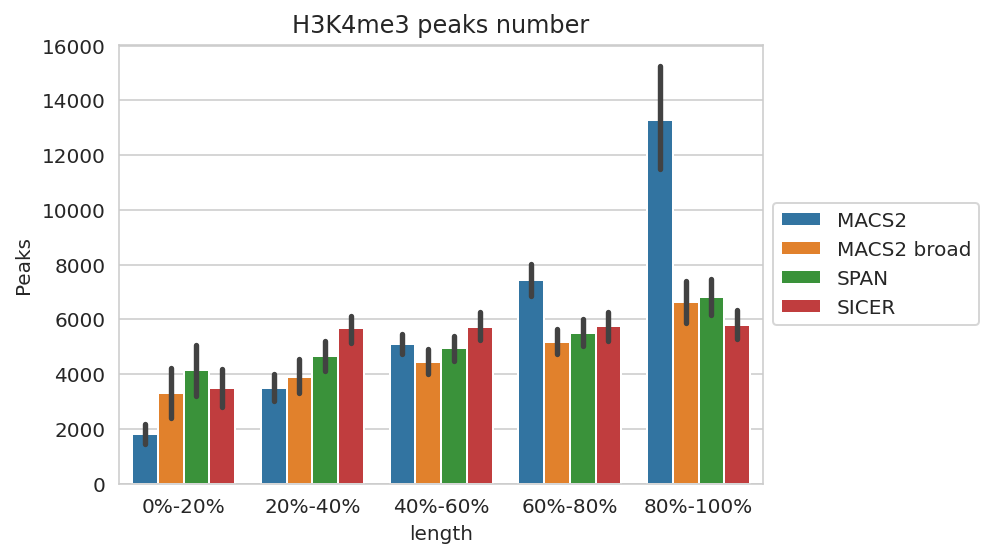

In [24]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.barplot(data=perc_peaks_df,
                        y='peaks', x='length', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        )
ax.title.set_text('H3K4me3 peaks number')
g_results.axes.set_ylabel('Peaks')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_peaks_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()

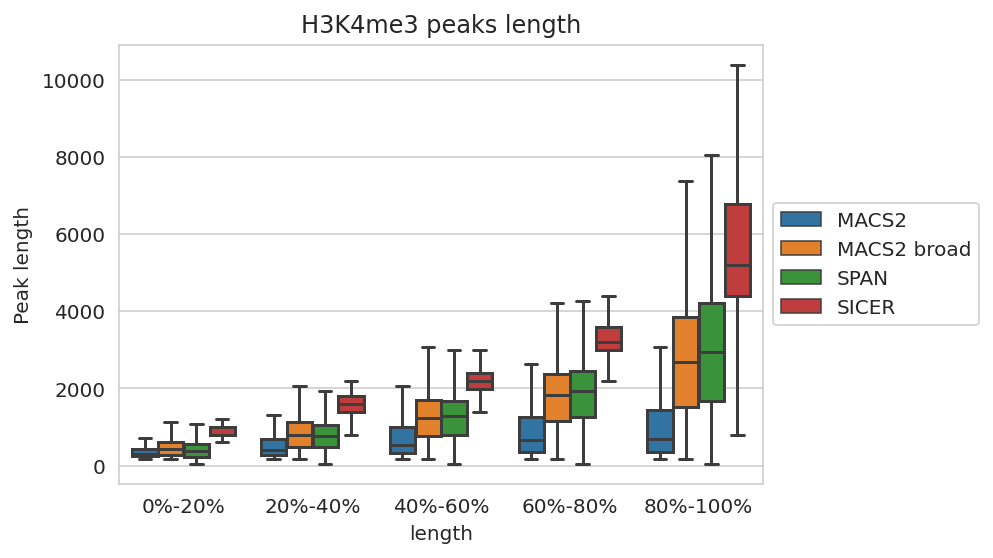

In [17]:
plt.figure(figsize=(7, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_len_df, x='length', y='peak_lengths', ax=ax,
                        hue='name',
                        hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K4me3 peaks length')
g_results.axes.set_ylabel('Peak length')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_peak_length_percentile.pdf', bbox_inches='tight', dpi=300)
plt.show()

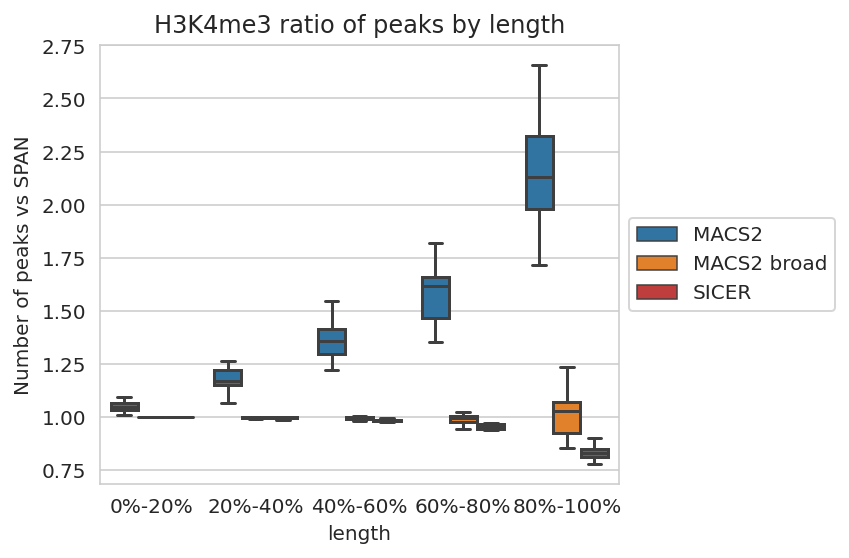

In [18]:
perc_ratio_df['tool_to_span'] = [d(t, s) for s, t in
                                 zip(perc_ratio_df['overlap_span_peaks'], perc_ratio_df['overlap_tool_peaks'])]

plt.figure(figsize=(6, 4))
ax = plt.axes()
g_results = sns.boxplot(data=perc_ratio_df, x='length', y='tool_to_span', ax=ax,
                        hue='tool',
                        hue_order=['MACS2', 'MACS2 broad', 'SICER'],
                        palette=TOOLS_PALETTE,
                        showfliers=False)
ax.title.set_text('H3K4me3 ratio of peaks by length')
g_results.axes.set_ylabel('Number of peaks vs SPAN')
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_ratios_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Consistency analysis between replicates

In [15]:
import tempfile
from itertools import product

reps_overlap = pd.DataFrame(columns=['modification', 'cell', 'tool', 'rep1', 'rep2',
                                     'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
                                     'peaks1_overlap', 'peaks1_overlap_len',
                                     'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

tf = tempfile.mktemp()

tools = list(sorted(set(df_fdr_peaks['tool'])))
for c, m in tqdm(product(GSE26320_CELLS, GSE26320_MODIFICATIONS)):
    print(c, m)
    tm = df_fdr_peaks[(df_fdr_peaks['cell'] == c) & (df_fdr_peaks['modification'] == m)]
    reps = list(sorted(set(tm['replicate'])))
    for tool in tools:
        for i in range(len(reps)):
            for j in range(i + 1, len(reps)):
                rep1, rep2 = reps[i], reps[j]
                t1 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep1)]
                t2 = tm[(tm['tool'] == tool) & (tm['replicate'] == rep2)]
                file1 = sorted_file(t1['file'].values[0])
                file2 = sorted_file(t2['file'].values[0])
                peaks1 = t1['peaks'].values[0]
                peaks1_len = int(bedl(file1).sum())
                peaks2 = t2['peaks'].values[0]
                peaks2_len = int(bedl(file2).sum())
                !bedtools intersect -a {file1} -b {file2} -wa -u > {tf}
                overlap1 = lines(tf)
                !bedtools intersect -b {file1} -a {file2} -wa -u > {tf}
                overlap2 = lines(tf)
                !bedtools intersect -a {file1} -b {file2} -wo > {tf}
                overlap1_len = overlap2_len = int(last_col(tf).sum())

                reps_overlap.loc[len(reps_overlap)] = \
                    (m, c, tool, rep1, rep2, peaks1, peaks1_len, peaks2, peaks2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)
reps_overlap.sample(5)

0it [00:00, ?it/s]

GM12878 H3K4me3
HMEC H3K4me3
HSMM H3K4me3
K562 H3K4me3
NHEK H3K4me3
NHLF H3K4me3
H1 H3K4me3
Huvec H3K4me3
HepG2 H3K4me3


modification   cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
15      H3K4me3   K562         SPAN  rep1  rep2   30611    56625186   28083   
8       H3K4me3   HSMM        MACS2  rep1  rep2   25114    27000649   26046   
16      H3K4me3   NHEK        MACS2  rep1  rep2   38852    31458600   39586   
9       H3K4me3   HSMM  MACS2 broad  rep1  rep2   23618    38809908   20422   
25      H3K4me3  Huvec  MACS2 broad  rep1  rep2   24934    39103549   16664   

    peaks2_len  peaks1_overlap  peaks1_overlap_len  peaks2_overlap  \
15    48448206           23577            42343484           23947   
8     24723059           20082            21604986           21934   
16    30256860           26351            22540409           29496   
9     32176364           17396            28342399           17632   
25    24715132           14424            22377634           15310   

    peaks2_overlap_len  
15            42343484  
8             21604986  
16            22540409  
9             28342399  
25            22377634

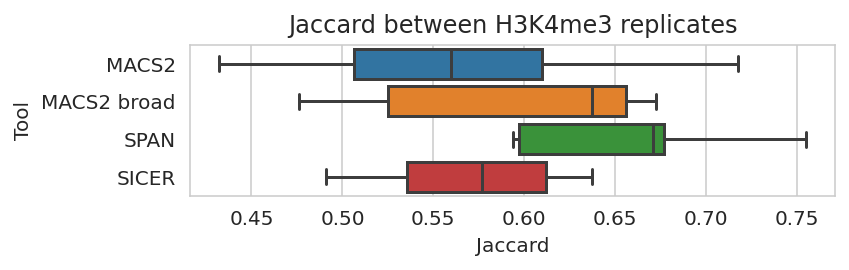

In [16]:
reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(reps_overlap['peaks1_len'], reps_overlap['peaks2_len'], reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(6, 2))

g_result = sns.boxplot(data=reps_overlap, y='tool', x='jaccard',
                       palette=TOOLS_PALETTE,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Jaccard between H3K4me3 replicates')
ax.set_xlabel('Jaccard')
ax.set_ylabel('Tool')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_replicates.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [17]:
from scipy.stats import wilcoxon
from scipy.stats import mannwhitneyu

jaccard_macs2 = reps_overlap[reps_overlap['tool'] == 'MACS2']['jaccard'].values
jaccard_macs2broad = reps_overlap[reps_overlap['tool'] == 'MACS2 broad']['jaccard'].values
jaccard_sicer = reps_overlap[reps_overlap['tool'] == 'SICER']['jaccard'].values
jaccard_span = reps_overlap[reps_overlap['tool'] == 'SPAN']['jaccard'].values

print(wilcoxon(jaccard_span, jaccard_macs2))
print(wilcoxon(jaccard_span, jaccard_macs2broad))
print(wilcoxon(jaccard_span, jaccard_sicer))

print(mannwhitneyu(jaccard_span, jaccard_macs2))
print(mannwhitneyu(jaccard_span, jaccard_macs2broad))
print(mannwhitneyu(jaccard_span, jaccard_sicer))

WilcoxonResult(statistic=7.0, pvalue=0.296875)
WilcoxonResult(statistic=6.0, pvalue=0.21875)
WilcoxonResult(statistic=4.0, pvalue=0.109375)
MannwhitneyuResult(statistic=36.0, pvalue=0.16491841491841494)
MannwhitneyuResult(statistic=33.0, pvalue=0.31759906759906764)
MannwhitneyuResult(statistic=37.0, pvalue=0.12820512820512822)


In [18]:
reps_overlap['peak1_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks1_overlap'], reps_overlap['peaks1'])]
reps_overlap['peak2_overlap_fraction'] = [d(x, y) for x, y in zip(reps_overlap['peaks2_overlap'], reps_overlap['peaks2'])]

reps_overlap['peak1_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks1_overlap_len'], reps_overlap['peaks1_len'])
]
reps_overlap['peak2_overlap_fraction_len'] = [
    d(x, y) for x, y in zip(reps_overlap['peaks2_overlap_len'], reps_overlap['peaks2_len'])
]
reps_overlap.sample(5)

modification     cell         tool  rep1  rep2  peaks1  peaks1_len  peaks2  \
26      H3K4me3    Huvec        SICER  rep1  rep2   24595    74793205   21074   
11      H3K4me3     HSMM         SPAN  rep1  rep2   19377    29804610   26793   
25      H3K4me3    Huvec  MACS2 broad  rep1  rep2   24934    39103549   16664   
14      H3K4me3     K562        SICER  rep1  rep2   30206    88614994   29338   
2       H3K4me3  GM12878        SICER  rep1  rep2   32672   119433328   31862   

    peaks2_len  peaks1_overlap  peaks1_overlap_len  peaks2_overlap  \
26    59212726           17873            47145251           17957   
11    39808372           18191            27951177           17745   
25    24715132           14424            22377634           15310   
14    88157062           24182            66228676           24293   
2    110795738           27067            89596889           27170   

    peaks2_overlap_len   jaccard  peak1_overlap_fraction  \
26            47145251  0.542769                0.726692   
11            27951177  0.670907                0.938793   
25            22377634  0.539987                0.578487   
14            66228676  0.599119                0.800569   
2             89596889  0.637101                0.828446   

    peak2_overlap_fraction  peak1_overlap_fraction_len  \
26                0.852093                    0.630341   
11                0.662300                    0.937814   
25                0.918747                    0.572266   
14                0.828039                    0.747376   
2                 0.852740                    0.750183   

    peak2_overlap_fraction_len  
26                    0.796201  
11                    0.702143  
25                    0.905422  
14                    0.751258  
2                     0.808667

In [19]:
t = pd.concat([
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak1_overlap_fraction', 'peak1_overlap_fraction_len']
    ].copy().rename(dict(peak1_overlap_fraction='overlap', peak1_overlap_fraction_len='overlap_len'), axis=1),
    reps_overlap[
        ['modification', 'cell', 'tool', 'peak2_overlap_fraction', 'peak2_overlap_fraction_len']
    ].copy().rename(dict(peak2_overlap_fraction='overlap', peak2_overlap_fraction_len='overlap_len'), axis=1)
]).reset_index(drop=True)
# t

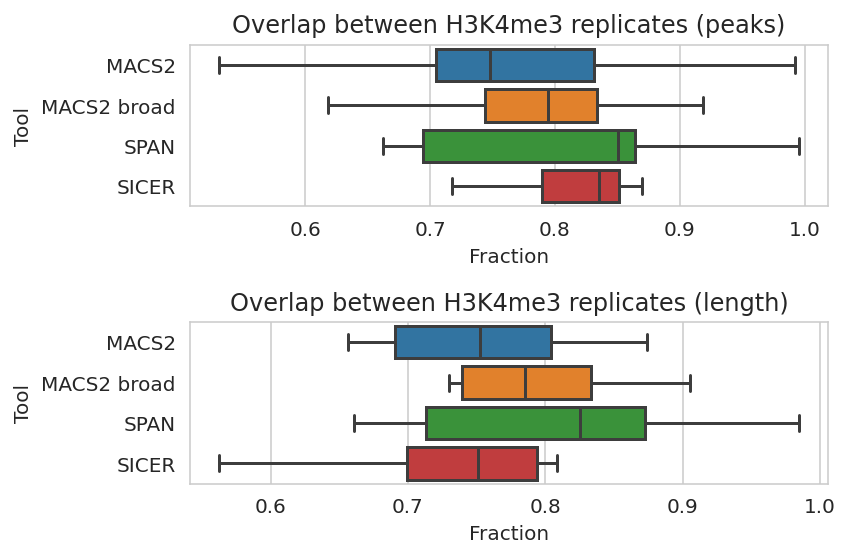

In [20]:
plt.figure(figsize=(6, 4))
axs = [plt.subplot(2, 1, i + 1) for i in range(2)]

g_result = sns.boxplot(data=t, y='tool', x='overlap', ax=axs[0],
                       palette=TOOLS_PALETTE,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K4me3 replicates (peaks)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

g_result = sns.boxplot(data=t, y='tool', x='overlap_len', ax=axs[1],
                       palette=TOOLS_PALETTE,
                       order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K4me3 replicates (length)')
ax.set_xlabel('Fraction')
ax.set_ylabel('Tool')

plt.tight_layout()
plt.show()

# Constistency analysis between replicates by length

In [19]:
import tempfile
from itertools import product

perc_reps_overlap = pd.DataFrame(
    columns=['modification', 'cell', 'tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)


for c in tqdm(GSE26320_CELLS):
    tf = tempfile.mktemp()
    tf2 = tempfile.mktemp()
    tf3 = tempfile.mktemp()

    print(c)
    try:
        rep_tool_map = {}
        for r, tool in product(GSE26320_REPS, ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']):
            t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K4me3') &
                             (df_fdr_peaks['cell'] == c) &
                             (df_fdr_peaks['replicate'] == r) &
                             (df_fdr_peaks['tool'] == tool)]
            if len(t) > 0:
                rep_tool_map[(r, tool)] = sorted_file(t['file'].values[0])
        # Prepare global overlap 
        tr1_macs2 = rep_tool_map[('rep1', 'MACS2')]
        tr1_macs2broad = rep_tool_map[('rep1', 'MACS2 broad')]
        tr1_span = rep_tool_map[('rep1', 'SPAN')]
        tr1_sicer = rep_tool_map[('rep1', 'SICER')]
        tr2_macs2 = rep_tool_map[('rep2', 'MACS2')]
        tr2_macs2broad = rep_tool_map[('rep2', 'MACS2 broad')]
        tr2_span = rep_tool_map[('rep2', 'SPAN')]
        tr2_sicer = rep_tool_map[('rep2', 'SICER')]
        # Prepare global overlap
        ! bedtools multiinter -i {tr1_macs2} {tr1_macs2broad} {tr1_span} {tr1_sicer} \
                {tr2_macs2} {tr2_macs2broad} {tr2_span} {tr2_sicer} > {tf}
        ! bedtools merge -i {tf} > {tf2}
        t = pd.read_csv(tf2, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            # Prepare tools percentage
            for tool in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
                r1file = rep_tool_map[('rep1', tool)]
                r2file = rep_tool_map[('rep2', tool)]
                ! bedtools intersect -wa -u -a {r1file} -b {sorted_file(tf)} > {r1file}-perc
                ! bedtools intersect -wa -u -a {r2file} -b {sorted_file(tf)} > {r2file}-perc
                r1file = f'{r1file}-perc'
                r2file = f'{r2file}-perc'
                r1_peaks = lines(r1file)
                r2_peaks = lines(r2file)
                r1_len = int(bedl(r1file).sum())
                r2_len = int(bedl(r2file).sum())
                !bedtools intersect -a {r1file} -b {r2file} -wa -u > {tf3}
                overlap1 = lines(tf3)
                !bedtools intersect -b {r1file} -a {r2file} -wa -u > {tf3}
                overlap2 = lines(tf3)
                !bedtools intersect -a {r1file} -b {r2file} -wo > {tf3}
                overlap1_len = overlap2_len = int(last_col(tf3).sum())
                perc_reps_overlap.loc[len(perc_reps_overlap)] = \
                    ('H3K27ac', c, tool, percentage_name, r1_peaks, r1_len, r2_peaks, r2_len,
                     overlap1, overlap1_len, overlap2, overlap2_len)

    except Exception as e:
        print(e)

perc_reps_overlap.sample(5)

  0%|          | 0/9 [00:00<?, ?it/s]

GM12878
HMEC
HSMM
K562
NHEK
NHLF
('rep1', 'MACS2')
H1
Huvec
HepG2
('rep1', 'MACS2')


NameError: name 'reps_overlap' is not defined

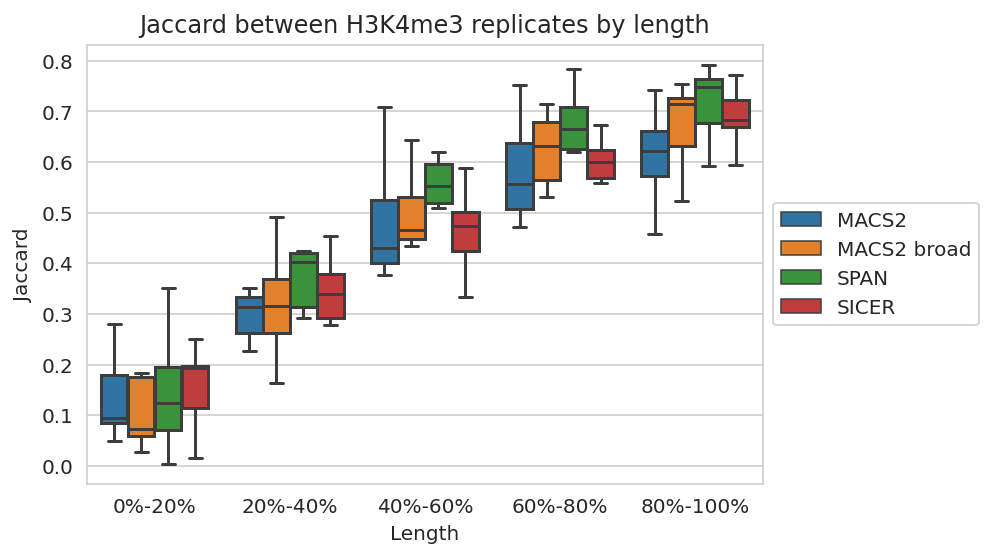

In [22]:
perc_reps_overlap['jaccard'] = [
    d(lo, l1 + l2 - lo)
    for l1, l2, lo in zip(perc_reps_overlap['peaks1_len'],
                          perc_reps_overlap['peaks2_len'], perc_reps_overlap['peaks1_overlap_len'])
]

plt.figure(figsize=(7, 4))

g_result = sns.boxplot(data=perc_reps_overlap, x='length_percentage', y='jaccard',
                       hue='tool',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Jaccard between H3K4me3 replicates by length')
ax.set_xlabel('Length')
ax.set_ylabel('Jaccard')
# Put a legend to the right of the current axis
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_replicates_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

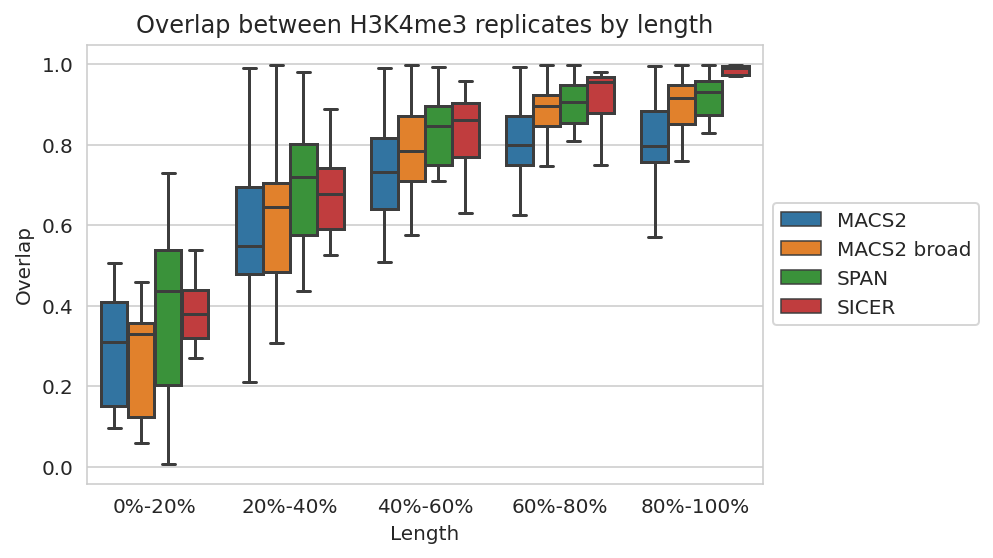

In [23]:
perc_reps_overlap['overlap1'] = [d(o, p) for o, p in
                                 zip(perc_reps_overlap['peaks1_overlap'], perc_reps_overlap['peaks1'])]
perc_reps_overlap['overlap2'] = [d(o, p) for o, p in
                                 zip(perc_reps_overlap['peaks2_overlap'], perc_reps_overlap['peaks2'])]

t = perc_reps_overlap[['tool', 'length_percentage', 'overlap1', 'overlap2']].copy().melt(
    id_vars=['tool', 'length_percentage'], value_vars=['overlap1', 'overlap2'])


plt.figure(figsize=(7, 4))

g_result = sns.boxplot(data=t, x='length_percentage', y='value',
                       hue='tool',
                       palette=TOOLS_PALETTE,
                       hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                       showfliers=False)
ax = g_result.axes
ax.set_title('Overlap between H3K4me3 replicates by length')
ax.set_xlabel('Length')
ax.set_ylabel('Overlap')
# Put a legend to the right of the current axis
g_result.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_replicates_overlap_by_length.pdf', bbox_inches='tight', dpi=300)
plt.show()

# H3K4me3 vs RNA-seq

Benchmark according to the paper https://doi.org/10.1093/bib/bbw035
Features that define the best ChIP-seq peak calling algorithms

We considered a peak as positive if it overlaps the promoter of an expressed gene (RPKM > 0.5).
The top 15 000 peak calls from the different methods are ranked by their significance or by their fold enrichment for the thresholding method. We plotted the correct peak fraction (fraction of the top 1000xn peaks that overlap with active promoters) detected as a function of the correct promoter fraction (fraction of the active promoters that overlap with the top 1000xn peaks).

## Load hg38 gtf

In [21]:
gtf_df = pd.read_csv(os.path.expanduser(
    '~/data/2023_Immune/gencode.GRCh38.p13.v41.annotation.gtf'),
    sep='\t', comment='#',
    names=['chromosome', 'db', 'type', 'start', 'end', 'point1', 'strand', 'point2', 'aux'])
gtf_df.sample(10)

chromosome      db         type      start        end point1 strand  \
1966460      chr11  HAVANA          CDS  119088635  119088707      .      +   
1699072      chr10  HAVANA          UTR   66280470   66280621      .      -   
6223          chr1  HAVANA         exon    1625286    1625428      .      +   
566801        chr2  HAVANA         exon  240775851  240776183      .      -   
2640034      chr17  HAVANA   transcript    6799981    6815177      .      -   
972354        chr5  HAVANA          CDS   71635151   71635246      .      +   
2852548      chr18  HAVANA          CDS   49490454   49490552      .      -   
49900         chr1  HAVANA  start_codon   25826667   25826669      .      +   
1906168      chr11  HAVANA          CDS   71442263   71442353      .      -   
1492497       chr8  HAVANA  start_codon  109644657  109644659      .      -   

        point2                                                aux  
1966460      0  gene_id "ENSG00000256269.11"; transcript_id "E...  
1699072      .  gene_id "ENSG00000183230.18"; transcript_id "E...  
6223         .  gene_id "ENSG00000197530.13"; transcript_id "E...  
566801       .  gene_id "ENSG00000130294.18"; transcript_id "E...  
2640034      .  gene_id "ENSG00000167858.13"; transcript_id "E...  
972354       0  gene_id "ENSG00000131844.17"; transcript_id "E...  
2852548      0  gene_id "ENSG00000265681.8"; transcript_id "EN...  
49900        0  gene_id "ENSG00000117640.18"; transcript_id "E...  
1906168      0  gene_id "ENSG00000172893.18"; transcript_id "E...  
1492497      0  gene_id "ENSG00000147642.17"; transcript_id "E...

In [22]:
import re

print('Parse GTF aux data')
auxes = {}
for i, aux in enumerate(tqdm(gtf_df['aux'])):
    for pair in aux.split(';'):
        kv = pair.strip().split(' ')
        if len(kv) != 2:
            continue
        k, v = kv
        if k not in auxes:
            auxes[k] = vs = []
        else:
            vs = auxes[k]
        vs.append(v.strip('"'))

for k, vs in auxes.items():
    if len(vs) == len(gtf_df):
        gtf_df[k] = vs
    else:
        print(f'Ignoring {k}')
del auxes
gtf_df.drop('aux', axis=1, inplace=True)

# Fix . in gene_id
gtf_df['gene_id'] = [re.sub('\..*', '', id) for id in gtf_df['gene_id']]

Parse GTF aux data


  0%|          | 0/3375759 [00:00<?, ?it/s]

Ignoring hgnc_id
Ignoring havana_gene
Ignoring transcript_id
Ignoring transcript_type
Ignoring transcript_name
Ignoring transcript_support_level
Ignoring tag
Ignoring havana_transcript
Ignoring exon_number
Ignoring exon_id
Ignoring ont
Ignoring protein_id
Ignoring ccdsid
Ignoring artif_dupl


In [23]:
print(f'Total hg38 records {len(gtf_df)}')
print(f'Total hg38 genes {sum(gtf_df["type"] == "gene")}')
print(f'Total hg38 protein_coding genes {sum((gtf_df["type"] == "gene") & (gtf_df["gene_type"] == "protein_coding"))}')

gtf_genes_df = gtf_df[gtf_df['type'] == 'gene']
gtf_genes_df.sample(5)

Total hg38 records 3375759
Total hg38 genes 61852
Total hg38 protein_coding genes 20017


chromosome       db  type      start        end point1 strand point2  \
1406277       chr8   HAVANA  gene    7112314    7113728      .      -      .   
3099144      chr20   HAVANA  gene   35648925   35664956      .      -      .   
1722707      chr10   HAVANA  gene   79499666   79499984      .      -      .   
1384372       chr7   HAVANA  gene  142399860  142400377      .      +      .   
3228321      chr22  ENSEMBL  gene   39313819   39313911      .      -      .   

                 gene_id             gene_type        gene_name level  
1406277  ENSG00000234120  processed_pseudogene  ENSG00000234120     1  
3099144  ENSG00000244462        protein_coding            RBM12     2  
1722707  ENSG00000259021  processed_pseudogene          TPRX1P1     2  
1384372  ENSG00000211717             TR_V_gene         TRBV10-1     2  
3228321  ENSG00000209480                snoRNA         SNORD83B     3

## Annotate quanitified RNA-seq with TSS positions

In [24]:
def merge_genes(full_df):
    print('Merging overlapping regions', len(full_df))
    ts = []
    for chr in full_df['chromosome'].unique():
        t = full_df[full_df['chromosome'] == chr].sort_values(by=['start', 'end']).copy()
        cols = t.columns.difference(['start', 'end'])
        grps = t['start'].sub(t['end'].shift()).gt(1).cumsum()
        gpby = t.groupby(grps)
        t = gpby.agg(dict(start='min', end='max')).join(gpby[cols].mean())
        t['chromosome'] = chr
        t['gene_id'] = 'merged'
        t['strand'] = '.'
        t = t[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
        ts.append(t)
    ts = pd.concat(ts).reset_index(drop=True)
    print('Reduced to', len(ts))
    return ts

In [25]:
import re

GSE26320_RNASEQ_PATH = os.path.expanduser('~/data/2023_GSE26320_rnaseq')

EXPRESSION_TSV = {
    ('GM12878', 'rep1') : 'GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv',
    ('GM12878', 'rep2'): 'GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv',
    ('H1', 'rep1') : 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('H1', 'rep2') : 'H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv',
    ('HMEC', 'rep1') : 'HMEC_rep1_RNAseq_hg38_ENCFF292FVY.tsv',
    ('HMEC', 'rep2') : 'HMEC_rep2_RNAseq_hg38_ENCFF219EZH.tsv',
    ('HSMM', 'rep1') : 'HSMM_rep1_RNAseq_hg38_ENCFF551YKI.tsv',
    ('HSMM', 'rep2') : 'HSMM_rep2_RNAseq_hg38_ENCFF497BUG.tsv',
    ('HepG2', 'rep1') : 'HepG2_rep1_RNAseq_hg38_ENCFF773JNC.tsv',
    ('HepG2', 'rep2') : 'HepG2_rep2_RNAseq_hg38_ENCFF570ZOT.tsv',
    ('Huvec', 'rep1') : 'Huvec_rep1_RNAseq_hg38_ENCFF454MTF.tsv',
    ('Huvec', 'rep2') : 'Huvec_rep2_RNAseq_hg38_ENCFF134FYP.tsv',
    ('K562', 'rep1') : 'K562_rep1_RNAseq_hg38_ENCFF139IXQ.tsv',
    ('K562', 'rep2') : 'K562_rep2_RNAseq_hg38_ENCFF088RDE.tsv',
    ('NHEK', 'rep1') : 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHEK', 'rep2') : 'NHEK_rep1_RNAseq_hg38_ENCFF004JWA.tsv',
    ('NHLF', 'rep1') : 'NHLF_rep1_RNAseq_hg38_ENCFF577DEC.tsv',
    ('NHLF', 'rep2') : 'NHLF_rep2_RNAseq_hg38_ENCFF412KNK.tsv'
}

EXPRESSION_TSS_BED = {}
TSS = 500
THRESHOLD = 0.1

for (cell, rep), path in tqdm(EXPRESSION_TSV.items()):
    print(cell, rep, path)
    t = pd.read_csv(GSE26320_RNASEQ_PATH + '/' + path, sep='\t')
    # Fix . in gene_id
    t['gene_id'] = [re.sub('\..*', '', id) for id in t['gene_id']]
    t['LTPM'] = np.log1p(t['TPM'])

    # # Plot expression
    # plt.figure(figsize=(10, 1))
    # ax = plt.axes()
    # g_results = sns.histplot(data=t, x='LTPM', ax=ax,
    #                          stat = 'density',
    #                          bins = 500, kde = True, alpha = 0.4)
    # ax.axvline(x=THRESHOLD, color='green')
    # ax.title.set_text(f'{cell} {rep} expression')
    # plt.show()
    #
    # Save expressed genes
    full_df = pd.merge(left=t, right=gtf_genes_df, left_on='gene_id', right_on='gene_id')
    print(f'Total genes with positions {len(full_df)}')
    full_df = full_df[full_df['LTPM'] > THRESHOLD]
    print(f'Genes logTPM > {THRESHOLD} {len(full_df)}')

    starts = [
        max(1, start - TSS if strand == '+' else end - TSS)
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    ends = [
        start + TSS if strand == '+' else end + TSS
        for start, end, strand in zip(full_df['start'], full_df['end'], full_df['strand'])
    ]
    full_df['start'] = starts
    full_df['end'] = ends
    full_df = full_df[['chromosome', 'start', 'end', 'gene_id', 'strand', 'TPM', 'LTPM']]
    full_df.sort_values(by=['chromosome', 'start'], inplace=True)
    full_df = merge_genes(full_df)
    # Plot expressed genes lengths
    # plt.figure(figsize=(4, 2))
    # ax = plt.axes()
    # g_results = sns.histplot(x=full_df['end']-full_df['start'], ax=ax,
    #                          stat='density',
    #                          bins=100, log_scale=True, kde=True, alpha=0.4)
    # g_results.set(xscale='log')
    # ax.title.set_text(f'{cell} genes lengths')
    # plt.show()

    expr_path = GSE26320_RNASEQ_PATH + '/' + path.replace('.tsv', f'_tpm{THRESHOLD}_tss{TSS}.bed')
    full_df.to_csv(expr_path, sep='\t', index=False, header=None)
    print(f'Saved expressed genes fom {cell} to {expr_path}')
    EXPRESSION_TSS_BED[(cell, rep)] = expr_path


  0%|          | 0/18 [00:00<?, ?it/s]

GM12878 rep1 GM12878_rep1_RNAseq_hg38_ENCFF723ICA.tsv
Total genes with positions 58387
Genes logTPM > 0.1 15835
Merging overlapping regions 15835
Reduced to 13836
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep1_RNAseq_hg38_ENCFF723ICA_tpm0.1_tss500.bed
GM12878 rep2 GM12878_rep2_RNAseq_hg38_ENCFF418FIT.tsv
Total genes with positions 56646
Genes logTPM > 0.1 15750
Merging overlapping regions 15750
Reduced to 13803
Saved expressed genes fom GM12878 to /home/jetbrains/data/2023_GSE26320_rnaseq/GM12878_rep2_RNAseq_hg38_ENCFF418FIT_tpm0.1_tss500.bed
H1 rep1 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv
Total genes with positions 56646
Genes logTPM > 0.1 19379
Merging overlapping regions 19379
Reduced to 17085
Saved expressed genes fom H1 to /home/jetbrains/data/2023_GSE26320_rnaseq/H1_rep1_RNAseq_hg38_ENCFF093NEQ_tpm0.1_tss500.bed
H1 rep2 H1_rep1_RNAseq_hg38_ENCFF093NEQ.tsv
Total genes with positions 56646
Genes logTPM > 0.1 19379
Merging overlapping regions

## Overlap H3K4me3 vs TSS expressed genes

In [26]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len', 'tss', 'tss_len',
             'peaks_overlap', 'peaks_overlap_len', 'tss_overlap', 'tss_overlap_len'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    tss_file = sorted_file(EXPRESSION_TSS_BED[c, r])
    tss = lines(tss_file)
    tss_length = int(bedl(tss_file).sum())
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        !bedtools intersect -a {peaks_file} -b {tss_file} -wa -u > {tf}
        peaks_overlap = lines(tf)
        !bedtools intersect -b {peaks_file} -a {tss_file} -wa -u > {tf}
        tss_overlap = lines(tf)
        !bedtools intersect -a {peaks_file} -b {tss_file} -wo > {tf}
        peaks_overlap_len = tss_overlap_len = int(last_col(tf).sum())

        bench_df.loc[len(bench_df)] = (c, r, tool, peaks, peaks_len, tss, tss_length,
                                       peaks_overlap, peaks_overlap_len, tss_overlap, tss_overlap_len)
# bench_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


In [27]:
bench_df['precision'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap'], bench_df['peaks'])]
bench_df['sensitivity'] = [d(a, b) for a, b in zip(bench_df['tss_overlap'], bench_df['tss'])]
bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                  for s, p in zip(bench_df['sensitivity'], bench_df['precision'])]

bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(bench_df['tss_overlap_len'], bench_df['tss_len'])]
bench_df['precision_len'] = [d(a, b) for a, b in zip(bench_df['peaks_overlap_len'], bench_df['peaks_len'])]
bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                      for s, p in zip(bench_df['sensitivity_len'], bench_df['precision_len'])]

bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(bench_df['peaks_len'], bench_df['tss_len'], bench_df['tss_overlap_len'])
]

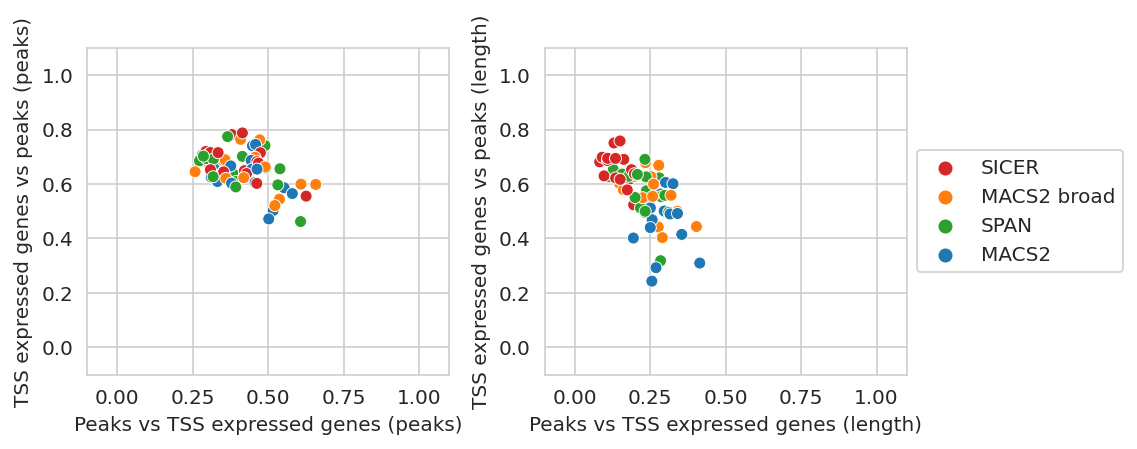

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]

ax = axs[0]
g_results = sns.scatterplot(data=bench_df, x='precision', y='sensitivity', hue='name',
                            palette=TOOLS_PALETTE,
                            # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            ax=ax)
g_results.axes.set_xlabel('Peaks vs TSS expressed genes (peaks)')
g_results.axes.set_ylabel('TSS expressed genes vs peaks (peaks)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
ax.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=bench_df, x='precision_len', y='sensitivity_len', hue='name',
                            palette=TOOLS_PALETTE,
                            # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            ax=ax)
g_results.axes.set_xlabel('Peaks vs TSS expressed genes (length)')
g_results.axes.set_ylabel('TSS expressed genes vs peaks (length)')
g_results.axes.set_xlim([-0.1, 1.1])
g_results.axes.set_ylim([-0.1, 1.1])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

In [29]:
ts = []
for name in bench_df['name'].unique():
    tn = bench_df[bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))

t = pd.concat(ts).reset_index(drop=True)
t.sort_values(by=['name'], inplace=True)
del ts

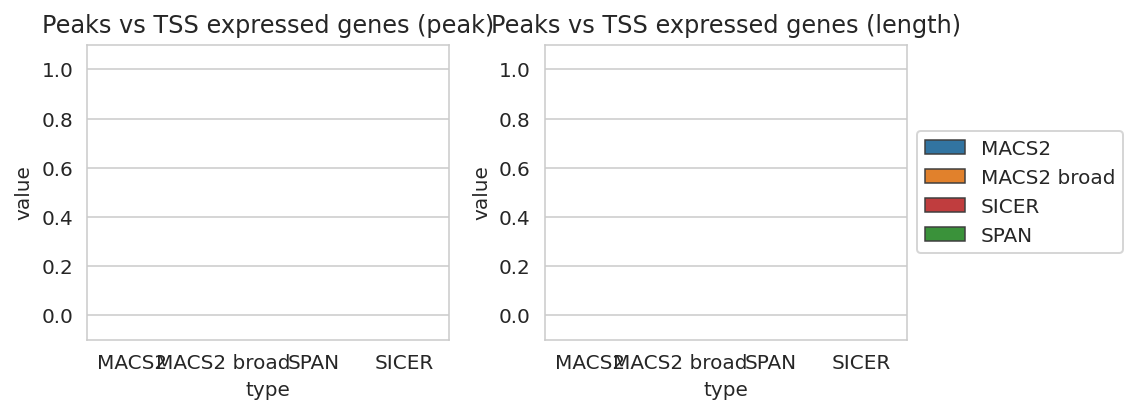

In [30]:
plt.figure(figsize=(8, 3))
axs = [plt.subplot(1, 2, i + 1) for i in range(2)]
for i, benchmark in enumerate(['peak', 'length']):
    g_results = sns.boxplot(data=t[t['benchmark'] == benchmark], x='type', y='value', hue='name',
                            palette=TOOLS_PALETTE,
                            order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            ax=axs[i])
    ax = g_results.axes
    ax.set_title(f'Peaks vs TSS expressed genes ({benchmark})')
    # Put a legend to the right of the current axis
    if i == 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    ax.set_ylim([-0.1, 1.1])

plt.tight_layout()
plt.show()

## Overlap H3K4me3 diff vs TSS expressed genes

In [31]:
TOOLS = list(sorted(set(bench_df['name'])))

diff_bench_df = pd.DataFrame(
    columns=['cell', 'replicate', 'name',
             'peaks', 'peaks_len',
             'tss', 'tss_len',
             'peaks_overlap', 'peaks_overlap_len',
             'tss_overlap', 'tss_overlap_len'],
    dtype=object
)

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    print(c, r)
    tss_file = sorted_file(EXPRESSION_TSS_BED[(c, r)])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    tss = lines(tss_file)
    tss_len = int(bedl(tss_file).sum())
    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            peaks_len = int(bedl(tf).sum())
            !bedtools intersect -a {tf} -b {tss_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            !bedtools intersect -b {tf} -a {tss_file} -wa -u > {tf2}
            tss_overlap = lines(tf2)
            !bedtools intersect -a {tf} -b {tss_file} -wo > {tf2}
            peaks_overlap_len = tss_overlap_len = int(last_col(tf2).sum())

            diff_bench_df.loc[len(diff_bench_df)] = \
                (c, r, name,
                 peaks, peaks_len,
                 tss, tss_len,
                 peaks_overlap, peaks_overlap_len,
                 tss_overlap, tss_overlap_len)

display(diff_bench_df.sample())

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate                name  peaks  peaks_len    tss   tss_len  \
69   H1      rep1  MACS2 broad - SPAN   2769    1376206  17085  17755384   

    peaks_overlap  peaks_overlap_len  tss_overlap  tss_overlap_len  
69            109              43746          110            43746

In [32]:
diff_bench_df['precision'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap'], diff_bench_df['peaks'])]
diff_bench_df['sensitivity'] = [d(a, b) for a, b in zip(diff_bench_df['tss_overlap'], diff_bench_df['tss'])]
diff_bench_df['f1'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                       for s, p in zip(diff_bench_df['sensitivity'], diff_bench_df['precision'])]

diff_bench_df['precision_len'] = [d(a, b) for a, b in zip(diff_bench_df['peaks_overlap_len'], diff_bench_df['peaks_len'])]
diff_bench_df['sensitivity_len'] = [d(a, b) for a, b in zip(diff_bench_df['tss_overlap_len'], diff_bench_df['tss_len'])]
diff_bench_df['f1_len'] = [d(2, d(1, s + 1e-10) + d(1, p + 1e-10))
                           for s, p in zip(diff_bench_df['sensitivity_len'], diff_bench_df['precision_len'])]

diff_bench_df['jaccard'] = [
    d(o, p + g -o)
    for p, g, o in zip(diff_bench_df['peaks_len'], diff_bench_df['tss_len'], diff_bench_df['tss_overlap_len'])
]

In [33]:
full_bench_df = pd.concat([bench_df,diff_bench_df]).reset_index(drop=True)
full_bench_df.sample(5)

cell replicate                name  peaks  peaks_len    tss   tss_len  \
127     NHLF      rep2  MACS2 broad - SPAN    438     174645  15634  16279106   
99      HSMM      rep2        SICER - SPAN    934    2128866  12942  13385517   
134       H1      rep1        SPAN - SICER    118      47492  17085  17755384   
4    GM12878      rep2               SICER  31862  110795738  13803  14363322   
129     NHLF      rep2        SICER - SPAN    434    1121966  15634  16279106   

     peaks_overlap  peaks_overlap_len  tss_overlap  tss_overlap_len  \
127             17               4030           17             4030   
99              21              17559           21            17559   
134              2                339            2              339   
4             9351           10030023         9931         10030023   
129             21              16225           21            16225   

     precision  sensitivity        f1  sensitivity_len  precision_len  \
127   0.038813     0.001087  0.002115         0.000248       0.023075   
99    0.022484     0.001623  0.003027         0.001312       0.008248   
134   0.016949     0.000117  0.000233         0.000019       0.007138   
4     0.293484     0.719481  0.416908         0.698308       0.090527   
129   0.048387     0.001343  0.002614         0.000997       0.014461   

       f1_len   jaccard  
127  0.000490  0.000245  
99   0.002264  0.001133  
134  0.000038  0.000019  
4    0.160276  0.087120  
129  0.001865  0.000933

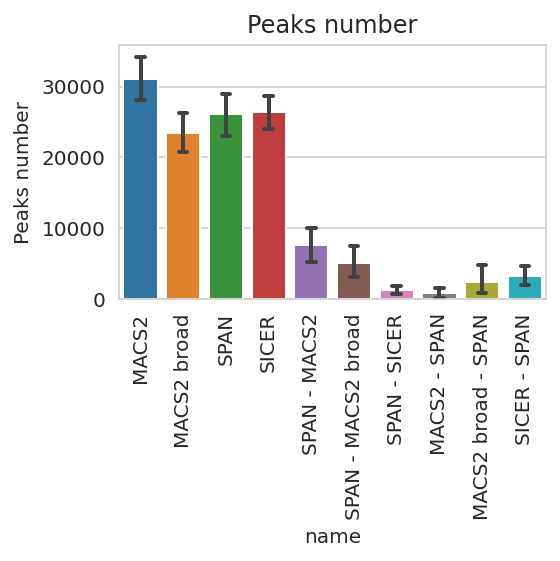

In [34]:
plt.figure(figsize=(4, 4))
ax = plt.axes()
ax.title.set_text('Peaks number')
g_results = sns.barplot(data=full_bench_df, x='name', y='peaks',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ]
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Peaks number')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_peaks.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Save benchmark df

In [35]:
full_bench_df.to_csv(GSE26320_PATH_HG38 + '/H3K4me3_full_bench_df.csv.gz', index=False, compression='gzip')

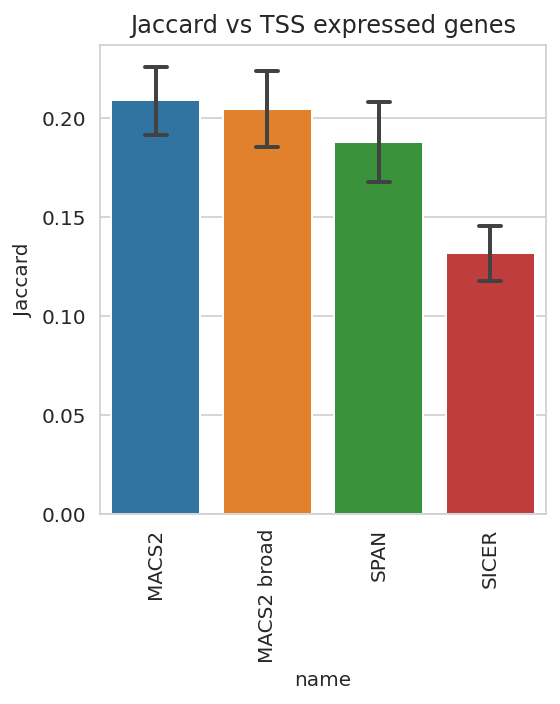

In [36]:
plt.figure(figsize=(4, 5))
ax = plt.axes()
ax.title.set_text('Jaccard vs TSS expressed genes')
g_results = sns.barplot(data=full_bench_df, x='name', y='jaccard',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [37]:
ts = []
for name in full_bench_df['name'].unique():
    tn = full_bench_df[full_bench_df['name'] == name]
    for variable in ['sensitivity', 'precision', 'f1']:
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['peak'] * len(tn),
                                    value=tn[variable])))
        ts.append(pd.DataFrame(dict(name=[name] * len(tn), type=[variable] * len(tn),
                                    benchmark=['length'] * len(tn),
                                    value=tn[f'{variable}_len'])))
t = pd.concat(ts).reset_index(drop=True)
del ts

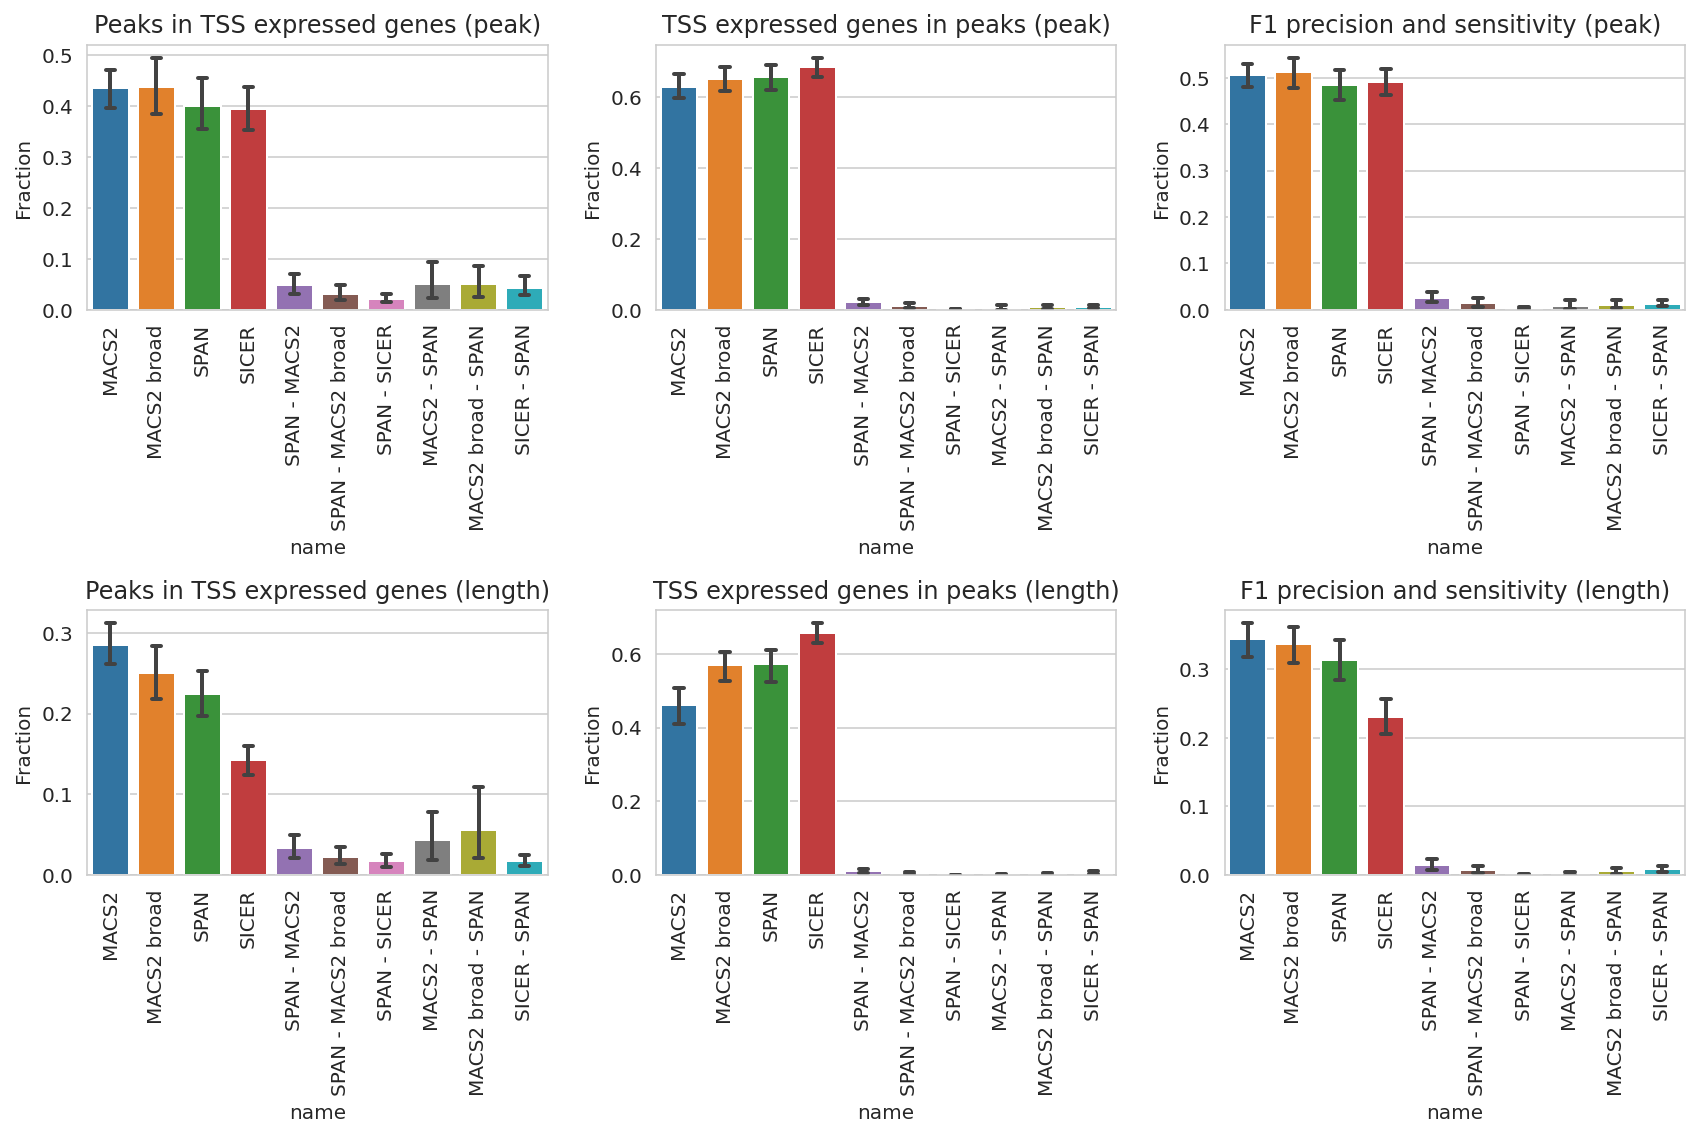

In [38]:
plt.figure(figsize=(12, 8))
axs = [plt.subplot(2, 3, i + 1) for i in range(6)]
for i, (benchmark, type) in enumerate(product(['peak', 'length'], ['precision', 'sensitivity', 'f1'])):
    ax = axs[i]
    if type == 'precision':
        ax.title.set_text(f'Peaks in TSS expressed genes ({benchmark})')
    elif type == 'sensitivity':
        ax.title.set_text(f'TSS expressed genes in peaks ({benchmark})')
    else:
        ax.title.set_text(f'F1 precision and sensitivity ({benchmark})')
    sns.barplot(data=t[(t['benchmark'] == benchmark) & (t['type'] == type)], x='name', y='value',
                capsize=.2, errwidth=2, ax=ax,
                order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                       'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                       'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                       ])
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_ylabel('Fraction')
plt.tight_layout()
plt.show()

# Venn diagram

In [39]:
from matplotlib_venn import venn2, venn3


def num_format(x, engineer):
    if x <= 0:
        return ''
    elif engineer:
        return f'{x:.0e}'
    else:
        return str(x)

num_format(1.3e10, True)

VENN2_SUBSETS = ['1', '2', '1,2']
VENN2_LABELS = ['10', '01', '11']

def venn2_overlap(ax, peaks1, peaks2, overlap12, overlap21, name1, name2,
                  show_numbers=True, engineer=False, add_proportion=False,
                  set_font=15, subset_font=10):
    max_peaks = max(peaks1, peaks2)
    max_overlap = max(overlap12, overlap21)
    # Tweak subsets to avoid empty areas
    if show_numbers:
        subsets = (
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks1 - overlap12)) if peaks1 > overlap12 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, peaks2 - overlap21)) if peaks2 > overlap21 else 0,
            max(0.1 * max_peaks, min(0.9 * max_peaks, max_overlap))
        )
    else:
        subsets = (peaks1 - overlap12, peaks2 - overlap21, max_overlap)
    v = venn2(subsets=subsets, set_labels=(name1, name2), alpha=0.3, ax=ax)
    # venn2_circles(subsets=subsets, color='grey', ax=ax)

    if show_numbers:
        v.get_label_by_id('10').set_text(num_format(peaks1 - overlap12, engineer))
        v.get_label_by_id('01').set_text(num_format(peaks2 - overlap21, engineer))
        if add_proportion:
            if overlap12 != 0 and overlap21 != 0:
                if overlap12 > overlap21:
                    prop = f'{overlap12 / overlap21:.1f} : 1'
                else:
                    prop = f'1 : {overlap21 / overlap12:.1f}'
                prop = prop.replace('.0', '')  # Cosmetics
            else:
                prop = ''
            v.get_label_by_id('11').set_text(f'{overlap12} : {overlap21}\n{prop}')
        else:
            v.get_label_by_id('11').set_text(num_format(max_overlap, engineer))
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    if not show_numbers:
        for l in VENN2_LABELS:
            label = v.get_label_by_id(l)
            if label is not None:
                label.set_text('')

VENN3_SUBSETS = ['1', '2', '1,2', '3', '1,3', '2,3', '1,2,3']
VENN3_LABELS = ['100', '010', '110', '001', '101', '011', '111']

def venn3_overlap(ax, v1, v2, v12, v3, v13, v23, v123, name1, name2, name3,
                  show_numbers=True, engineer=False,
                  set_font=15, subset_font=10):
    subsets=(v1, v2, v12, v3, v13, v23, v123)
    t = {l: s for l, s in zip(VENN3_LABELS, subsets)}
    v = venn3(subsets=subsets,
              set_labels=(name1, name2, name3),
              alpha=0.3,
              ax=ax)
    for text in v.set_labels:
        if text is not None:
            text.set_fontsize(set_font)
    for text in v.subset_labels:
        if text is not None:
            text.set_fontsize(subset_font)
    for l in VENN3_LABELS:
        label = v.get_label_by_id(l)
        if label is not None:
            if not show_numbers:
                label.set_text('')
            else:
                label.set_text(num_format(t[l], engineer))

0it [00:00, ?it/s]

GM12878 rep1
Venn diagrams of SPAN vs other tools (peaks)


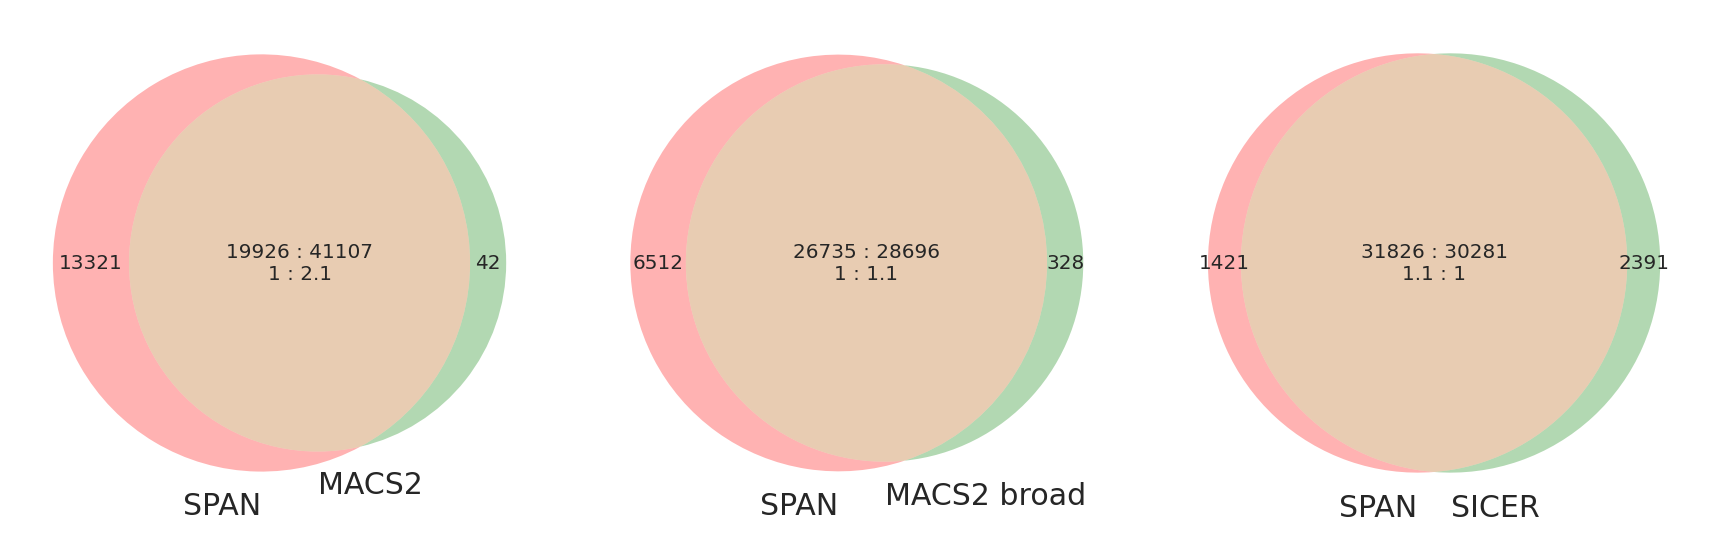

Venn diagram of SPAN vs other tools and TSS expressed genes (ranges)


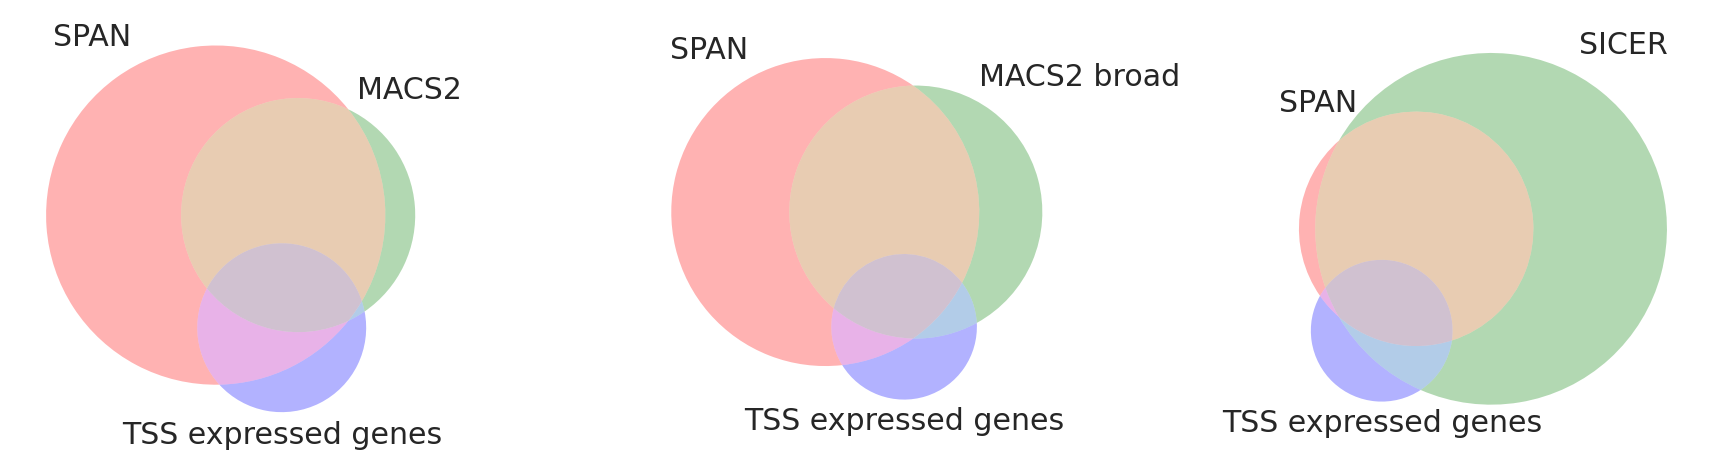

Venn diagram of SPAN vs other tools and TSS expressed genes (length)
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!
Error: The requested file ({span_file}) could not be opened. Error message: (No such file or directory). Exiting!


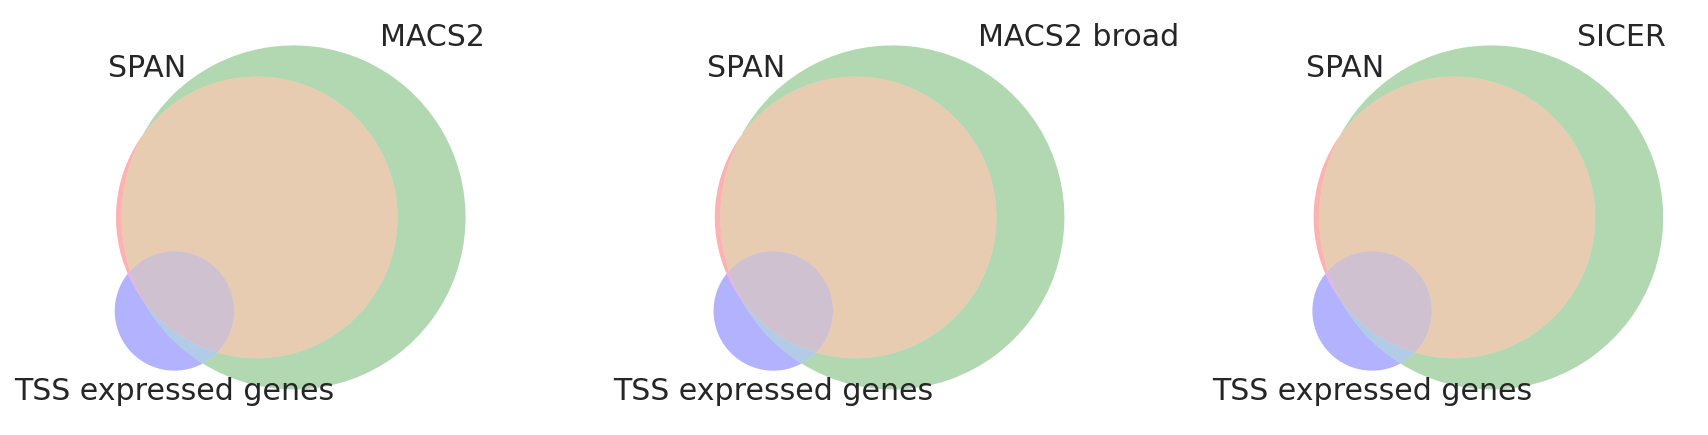

In [40]:
other_tools = list(sorted(filter(lambda t: t != 'SPAN', bench_df['name'].unique())))

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

for c, r in tqdm(product(['GM12878'], ['rep1'])):
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    print(c, r)
    tss_file = sorted_file(EXPRESSION_TSS_BED[(c,r)])
    t = df_fdr_peaks[(df_fdr_peaks['tool'] == 'SPAN') & (df_fdr_peaks['modification'] == 'H3K4me3') &
                     (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
    if len(t) == 0:
        continue
    span_file = sorted_file(t['file'].values[0])
    span_peaks = lines(span_file)
    span_len = int(bedl(span_file).sum())
    tss_peaks = lines(tss_file)
    tss_length = int(bedl(tss_file).sum())

    print('Venn diagrams of SPAN vs other tools (peaks)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        !bedtools intersect -a {span_file} -b {peaks_file} -wa -u > {tf}
        span_overlap = lines(tf)
        !bedtools intersect -b {span_file} -a {peaks_file} -wa -u > {tf}
        other_overlap = lines(tf)
        venn2_overlap(axs[i], span_peaks, peaks_number, span_overlap, other_overlap, 'SPAN', tool,
                      show_numbers=True, add_proportion=True)
    plt.tight_layout()
    # plt.savefig(f'{GSE26320_PATH}/analyze/venn_{m}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print('Venn diagram of SPAN vs other tools and TSS expressed genes (ranges)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {tss_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[(t['overlap_details'] == o).sum() for o in VENN3_SUBSETS],
                      'SPAN', tool, 'TSS expressed genes',
                      show_numbers=False, engineer=True)
    plt.tight_layout()
    plt.show()

    print('Venn diagram of SPAN vs other tools and TSS expressed genes (length)')
    plt.figure(figsize=(4 * len(other_tools), 4))
    axs = [plt.subplot(1, len(other_tools), i + 1) for i in range(len(other_tools))]
    for i, tool in enumerate(other_tools):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks_number = lines(peaks_file)
        peaks_len = int(bedl(peaks_file).sum())
        ! bedtools multiinter -i {span_file} {peaks_file} {expr_file} > {tf}
        t = pd.read_csv(tf, sep='\t', names=['chr', 'start', 'end',
                                             'overlap_number', 'overlap_details',
                                             'overlap1', 'overlap2', 'overlap3'])
        venn3_overlap(axs[i], *[
            (t[t['overlap_details'] == o]['end'] - t[t['overlap_details'] == o]['start']).sum()
            for o in VENN3_SUBSETS
        ], 'SPAN', tool, 'TSS expressed genes', show_numbers=False, engineer=True)

    plt.tight_layout()
    plt.show()

# Hg38 Recovered promoter fraction / Correct peak fraction

In [41]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

benchmark_cpf_df = pd.DataFrame(
    columns=['cell', 'replicate', 'top', 'genes', 'peaks_file', 'peaks', 'pg', 'gp', 'tool'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if (c, r) not in EXPRESSION_TSS_BED:
        continue
    tss_file = sorted_file(EXPRESSION_TSS_BED[c, r])
    tss = lines(tss_file)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        t.sort_values(by=[8] if len(t.columns) >= 9 else [4], ascending=False, inplace=True)
        for top in np.linspace(1000, 15000, 15):
            t.head(int(top)).sort_values(by=[0, 1]).to_csv(tf, sep='\t', index=False, header=None)
            tf = sorted_file(tf)
            peaks = lines(tf)
            ! bedtools intersect -a {tf} -b {tss_file} -wa -u > {tf2}
            peaks_overlap = lines(tf2)
            ! bedtools intersect -b {tf} -a {tss_file} -wa -u > {tf2}
            tss_overlap = lines(tf2)
            benchmark_cpf_df.loc[len(benchmark_cpf_df)] = \
                (c, r, top, tss, peaks_file, peaks, peaks_overlap, tss_overlap, tool)

benchmark_cpf_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate      top  genes        peaks_file  peaks     pg    gp  \
0    GM12878      rep1   1000.0  13836  /tmp/tmphyg1m8_0   1000    682   811   
1    GM12878      rep1   2000.0  13836  /tmp/tmphyg1m8_0   2000   1345  1564   
2    GM12878      rep1   3000.0  13836  /tmp/tmphyg1m8_0   3000   1964  2242   
3    GM12878      rep1   4000.0  13836  /tmp/tmphyg1m8_0   4000   2535  2853   
4    GM12878      rep1   5000.0  13836  /tmp/tmphyg1m8_0   5000   3051  3416   
..       ...       ...      ...    ...               ...    ...    ...   ...   
955    HepG2      rep2  11000.0  14951  /tmp/tmp3a0qo949  11000   8425  7635   
956    HepG2      rep2  12000.0  14951  /tmp/tmp3a0qo949  12000   8996  8026   
957    HepG2      rep2  13000.0  14951  /tmp/tmp3a0qo949  13000   9463  8304   
958    HepG2      rep2  14000.0  14951  /tmp/tmp3a0qo949  14000   9881  8531   
959    HepG2      rep2  15000.0  14951  /tmp/tmp3a0qo949  15000  10280  8737   

      tool  
0    SICER  
1    SICER  
2    SICER  
3    SICER  
4    SICER  
..     ...  
955  MACS2  
956  MACS2  
957  MACS2  
958  MACS2  
959  MACS2  

[960 rows x 9 columns]

In [42]:
benchmark_cpf_df['p'] = (benchmark_cpf_df['pg'] + benchmark_cpf_df['gp']) / 2
benchmark_cpf_df['precision'] = [d(x, y) for x, y in zip(benchmark_cpf_df['pg'], benchmark_cpf_df['peaks'])]
benchmark_cpf_df['sensitivity'] = [d(x, y) for x, y in zip(benchmark_cpf_df['gp'], benchmark_cpf_df['genes'])]
benchmark_cpf_df['f1'] = [2 / (d(1, s + 1e-10) + d(1, p + 1e-10)) for s, p in zip(benchmark_cpf_df['sensitivity'], benchmark_cpf_df['precision'])]
benchmark_cpf_df

cell replicate      top  genes        peaks_file  peaks     pg    gp  \
0    GM12878      rep1   1000.0  13836  /tmp/tmphyg1m8_0   1000    682   811   
1    GM12878      rep1   2000.0  13836  /tmp/tmphyg1m8_0   2000   1345  1564   
2    GM12878      rep1   3000.0  13836  /tmp/tmphyg1m8_0   3000   1964  2242   
3    GM12878      rep1   4000.0  13836  /tmp/tmphyg1m8_0   4000   2535  2853   
4    GM12878      rep1   5000.0  13836  /tmp/tmphyg1m8_0   5000   3051  3416   
..       ...       ...      ...    ...               ...    ...    ...   ...   
955    HepG2      rep2  11000.0  14951  /tmp/tmp3a0qo949  11000   8425  7635   
956    HepG2      rep2  12000.0  14951  /tmp/tmp3a0qo949  12000   8996  8026   
957    HepG2      rep2  13000.0  14951  /tmp/tmp3a0qo949  13000   9463  8304   
958    HepG2      rep2  14000.0  14951  /tmp/tmp3a0qo949  14000   9881  8531   
959    HepG2      rep2  15000.0  14951  /tmp/tmp3a0qo949  15000  10280  8737   

      tool       p  precision  sensitivity        f1  
0    SICER   746.5   0.682000     0.058615  0.107952  
1    SICER  1454.5   0.672500     0.113038  0.193545  
2    SICER  2103.0   0.654667     0.162041  0.259782  
3    SICER  2694.0   0.633750     0.206201  0.311161  
4    SICER  3233.5   0.610200     0.246892  0.351546  
..     ...     ...        ...          ...       ...  
955  MACS2  8030.0   0.765909     0.510668  0.612772  
956  MACS2  8511.0   0.749667     0.536820  0.625636  
957  MACS2  8883.5   0.727923     0.555414  0.630074  
958  MACS2  9206.0   0.705786     0.570597  0.631032  
959  MACS2  9508.5   0.685333     0.584376  0.630841  

[960 rows x 13 columns]

In [43]:
def rgb2hex(color):
    r, g, b, _ = color
    return "#{0:02x}{1:02x}{2:02x}".format(int(r * 255), int(g * 255), int(b * 255))

PLOTLY_TOOLS_PALETTE = {k: rgb2hex(v) for k, v in TOOLS_PALETTE.items()}

In [44]:
import plotly.graph_objects as go
from plotly.io import write_image

def plot_top(benchmark_cpf_df):
    tools_legend_shown = set()
    fig = go.Figure()

    for c, r, t in product(GSE26320_CELLS, GSE26320_REPS, df_fdr_peaks['tool'].unique()):
        dft = benchmark_cpf_df[(benchmark_cpf_df['cell'] == c) &
                           (benchmark_cpf_df['replicate'] == r) &
                           (benchmark_cpf_df['tool'] == t)]
        if len(dft) == 0:
            continue
        fig.add_trace(go.Scatter(
            x=dft["precision"], y=dft["sensitivity"], mode='lines+markers', name=t,
            hovertext=dft['top'].astype(str) + ' ' + t,
            showlegend=t not in tools_legend_shown,
            marker_color=PLOTLY_TOOLS_PALETTE[t],
            opacity=0.8,
        ))
        tools_legend_shown.add(t)

    # fig.update_xaxes(range=[-0.1, 1.1], title='Correct promoter fraction (sensitivity)')
    # fig.update_yaxes(range=[-0.1, 1.1], title='Recovered promoter fraction (precision)')
    fig.update_xaxes(title='Correct promoter fraction (sensitivity)')
    fig.update_yaxes(title='Recovered promoter fraction (precision)')

    fig.layout.template = 'plotly_white'
    fig.update_layout(
        autosize=False,
        width=800,
        height=600,)
    fig.show()

In [45]:
plot_top(benchmark_cpf_df[(benchmark_cpf_df['cell'] == 'GM12878') & (benchmark_cpf_df['replicate'] == 'rep1')])

In [46]:
plot_top(benchmark_cpf_df)

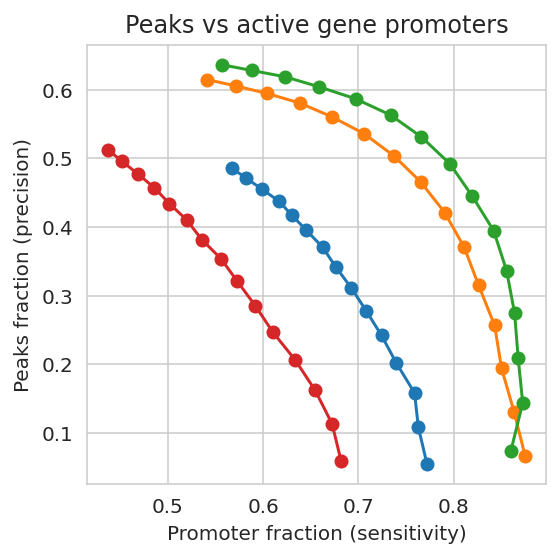

In [47]:
plt.figure(figsize=(4, 4))
for t in ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']:
    tt = benchmark_cpf_df[(benchmark_cpf_df['cell'] == 'GM12878') &
                          (benchmark_cpf_df['replicate'] == 'rep1') &
                          (benchmark_cpf_df['tool'] == t)]
    plt.plot(tt['precision'], tt['sensitivity'], marker='o', label=t)
plt.title('Peaks vs active gene promoters')
plt.xlabel('Promoter fraction (sensitivity)')
plt.ylabel('Peaks fraction (precision)')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_promoters.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Average precision

AP summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight:

AP = ∑(Rn−Rn−1)*Pn, where  Pn and Rn are the precision and recall at the nth threshold.

This implementation is not interpolated and is different from computing the area under the precision-recall curve with the trapezoidal rule, which uses linear interpolation and can be too optimistic.

In [48]:
cells = []
reps = []
tools = []
aps = []
for c, r, t in tqdm(product(GSE26320_CELLS, GSE26320_REPS, set(df_fdr_peaks['tool']))):
    dft = benchmark_cpf_df[(benchmark_cpf_df['cell'] == c) &
                           (benchmark_cpf_df['replicate'] == r) &
                           (benchmark_cpf_df['tool'] == t)].copy()
    if len(dft) == 0:
        continue
    ap = 0
    rprev = 0
    for _, row in dft.iterrows():
        ap += (row['sensitivity'] - rprev)*row['precision']
        rprev = row['sensitivity']
    cells.append(c)
    reps.append(r)
    tools.append(t)
    aps.append(ap)
aps_df = pd.DataFrame(dict(cell=cells, replicate=reps, tool=tools, ap=aps))

0it [00:00, ?it/s]

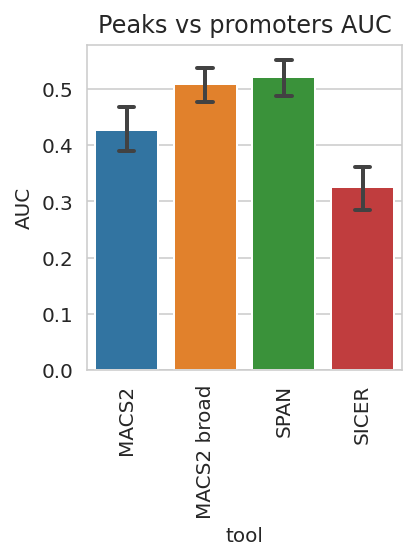

In [49]:
plt.figure(figsize=(3, 4))
ax = plt.axes()
ax.title.set_text('Peaks vs promoters AUC')
g_results = sns.barplot(data=aps_df, x='tool', y='ap',
                        ax=ax,
                        capsize=.2, errwidth=2,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
                        )
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('AUC')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_auc.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Functional annotations

In [50]:
import tempfile
from itertools import product

tf = tempfile.mktemp()

! rm -r {GSE26320_PATH_HG38}/summary_H3K4me3
! mkdir -p {GSE26320_PATH_HG38}/summary_H3K4me3

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        filename = tool.replace(' ', '_')
        ! cat {peaks_file} >> "{GSE26320_PATH_HG38}/summary_H3K4me3/{filename}.bed_"
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            filename = name.replace(' ', '_')
            ! cat {tf} >> "{GSE26320_PATH_HG38}/summary_H3K4me3/{filename}.bed_"

for f in os.listdir(GSE26320_PATH_HG38 + '/summary_H3K4me3'):
    f_sorted = f[:len(f) - 1]
    ! sort -k1,1 -k2,2n -k3,3n "{GSE26320_PATH_HG38}/summary_H3K4me3/{f}" | cut -f1-3> "{GSE26320_PATH_HG38}/summary_H3K4me3/{f_sorted}"
    ! rm "{GSE26320_PATH_HG38}/summary_H3K4me3/{f}"

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


# Coverage

In [7]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [8]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K4me3')
display(bws_df.sample(1))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(1))

  0%|          | 0/103 [00:00<?, ?it/s]

file modification  cell  \
8  /home/jetbrains/data/2023_GSE26320/bw/GSM64638...      H3K4me3  HMEC   

  replicate  
8      rep1

  0%|          | 0/103 [00:00<?, ?it/s]

file modification  cell  \
2  /home/jetbrains/data/2023_GSE26320/bw/GSM64649...        Input  NHLF   

  replicate  
2      rep2

In [9]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [10]:
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K4me3') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

GM12878 rep1
SPAN /tmp/tmp8_o69mfr /home/jetbrains/data/2023_GSE26320/bw/GSM646326_GM12878_H3K4me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 broad /tmp/tmpqdl07eoq /home/jetbrains/data/2023_GSE26320/bw/GSM646326_GM12878_H3K4me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 /tmp/tmp6o0jh8mj /home/jetbrains/data/2023_GSE26320/bw/GSM646326_GM12878_H3K4me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SICER /tmp/tmpqlpjpcki /home/jetbrains/data/2023_GSE26320/bw/GSM646326_GM12878_H3K4me3_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
GM12878 rep2
SPAN /tmp/tmpi1s3wi33 /home/jetbrains/data/2023_GSE26320/bw/GSM646327_GM12878_H3K4me3_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
MACS2 broad /tmp/tmpuqc4gspv /home/jetbrains/data/2023_GSE26320/bw/GSM646327_GM12878_H3K4me3_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646

cell replicate                                            bw_file  \
0   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
1   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
2   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
3   GM12878      rep1  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
4   GM12878      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64632...   
..      ...       ...                                                ...   
59    Huvec      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64642...   
60    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   
61    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   
62    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   
63    HepG2      rep2  /home/jetbrains/data/2023_GSE26320/bw/GSM64636...   

           tool        peaks_file  peaks     length  reads_in_peaks  \
0          SPAN  /tmp/tmp8_o69mfr  33247   80025639    3.368087e+07   
1   MACS2 broad  /tmp/tmpqdl07eoq  29024   58752715    2.952103e+07   
2         MACS2  /tmp/tmp6o0jh8mj  41149   29831660    2.156396e+07   
3         SICER  /tmp/tmpqlpjpcki  32672  119433328    3.851723e+07   
4          SPAN  /tmp/tmpi1s3wi33  31195   73769463    4.162837e+07   
..          ...               ...    ...        ...             ...   
59        SICER  /tmp/tmp5z0_ad_5  21074   59212726    4.548393e+07   
60         SPAN  /tmp/tmpq8rklrdd  35833   47813134    6.184653e+07   
61  MACS2 broad  /tmp/tmptmdh1r5r  19637   27327495    5.414456e+07   
62        MACS2  /tmp/tmpt9_6wjst  27438   22532198    5.123309e+07   
63        SICER  /tmp/tmp3z4612lj  30452   80370548    6.569289e+07   

       all_reads  control_reads_in_peaks  control_all_reads  
0   9.806705e+07            4.128673e+06       9.857266e+07  
1   9.804659e+07            2.716950e+06       9.857266e+07  
2   9.804659e+07            1.240239e+06       9.857266e+07  
3   9.801511e+07            5.957738e+06       9.857266e+07  
4   9.729126e+07            3.989482e+06       9.838476e+07  
..           ...                     ...                ...  
59  7.645104e+07            5.389017e+06       7.680974e+07  
60  7.792110e+07            8.028795e+05       8.412824e+07  
61  7.788793e+07            2.056198e+05       8.412824e+07  
62  7.788793e+07            8.504046e+04       8.412824e+07  
63  7.784647e+07            1.589569e+06       8.412824e+07  

[64 rows x 11 columns]

In [11]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / ((z + 1e-10) / 1e3)) / ((y + 1e-10) / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

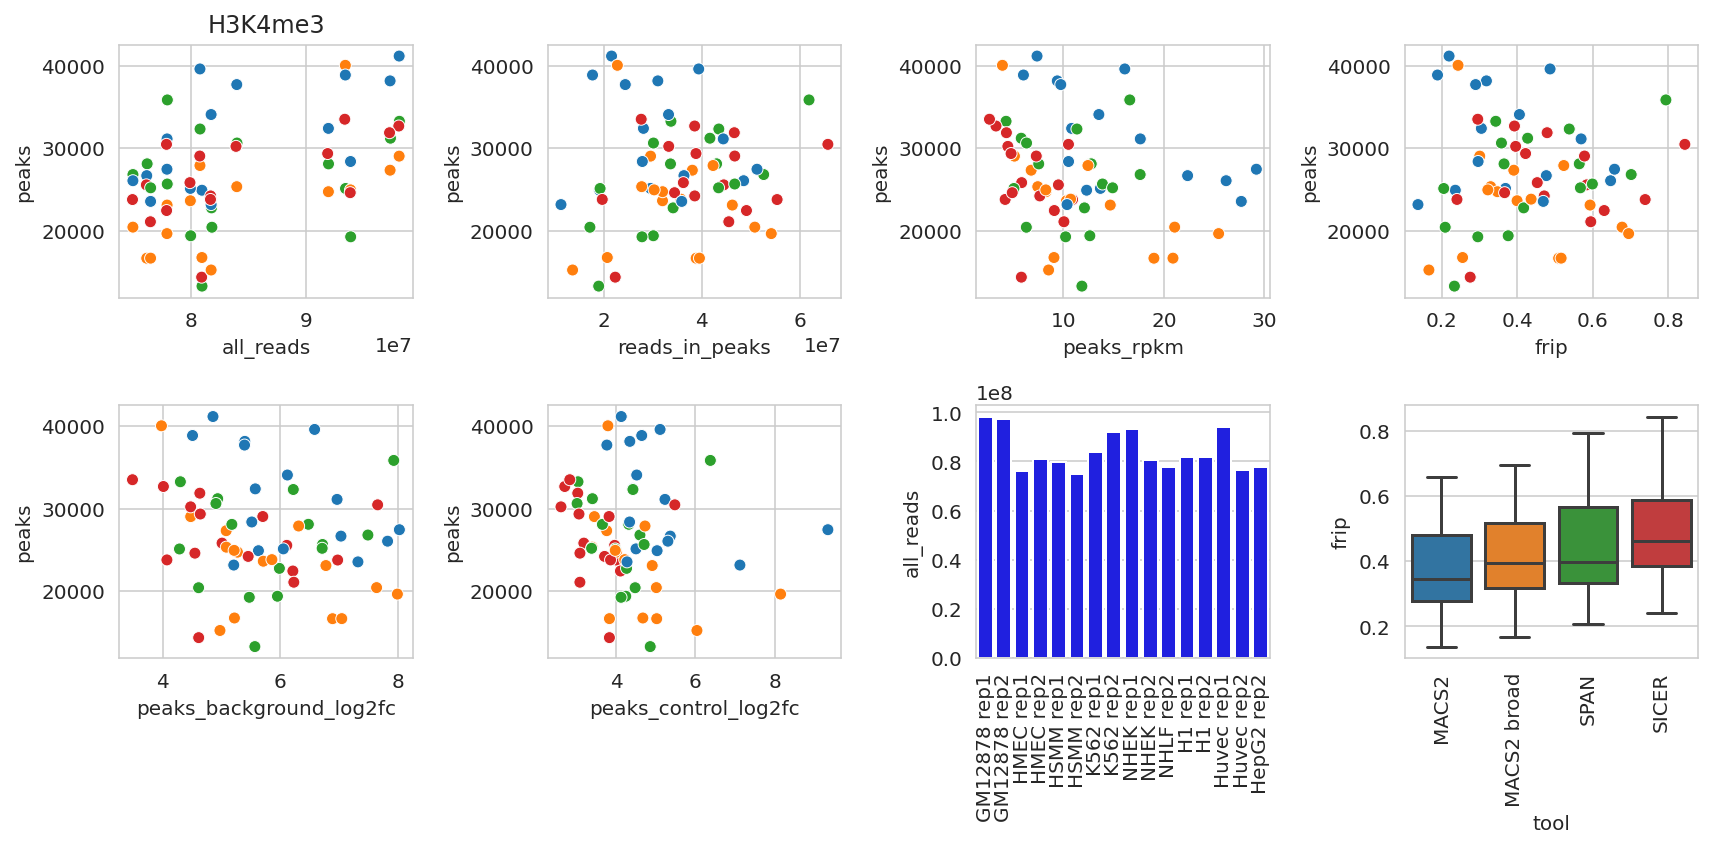

In [12]:
import seaborn as sns
t = frip_df
plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K4me3')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
tt = t[t['tool'] == 'SPAN']
g_results = sns.barplot(x=tt['cell'] + ' ' + tt['replicate'], y=tt['all_reads'],
                        color='Blue',
                        # order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='frip',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_reads.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [14]:
frip_df.to_csv(f'{GSE26320_PATH_HG38}/pics/H3K4me3_frip.csv.gz', index=None, compression='gzip')

## Peaks density

In [13]:
import pyBigWig

tf = tempfile.mktemp()

coverage_data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = bws_df[(bws_df['modification'] == 'H3K4me3') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K4me3', c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K4me3', c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


modification     cell replicate                name  \
1090770      H3K4me3     HSMM      rep1               MACS2   
604769       H3K4me3  GM12878      rep2  SPAN - MACS2 broad   
1344367      H3K4me3     HSMM      rep2               MACS2   
631616       H3K4me3     HMEC      rep1                SPAN   
184447       H3K4me3  GM12878      rep1               SICER   

                         position  length       type     coverage  \
1090770    chr1:22052233-22054250    2017    control    97.715621   
604769     chr1:34796924-34797125     201    control     0.000000   
1344367   chr22:37512110-37512303     193    control     0.000000   
631616    chr19:47483515-47485331    1816  treatment  2033.299194   
184447   chr1:244652200-244657799    5599    control   245.621616   

         total_coverage  
1090770    8.318205e+07  
604769     9.843952e+07  
1344367    5.874353e+07  
631616     7.610043e+07  
184447     9.857266e+07

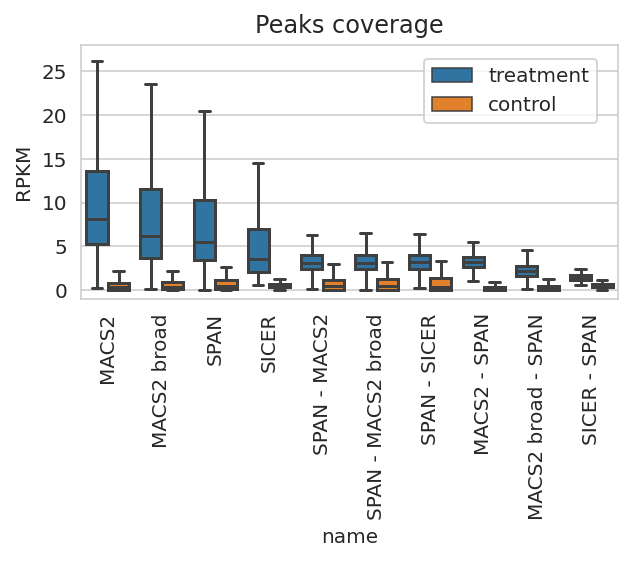

In [14]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type', showfliers = False,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ])
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 28)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_coverage.pdf', bbox_inches='tight', dpi=300)
plt.show()

# ChromHMM

In [59]:
CHROMHMM_MAP = {
    'GM12878': GSE26320_PATH_HG38 + '/chromhmm/GM12878_chromhmm_hg38_ENCFF338RIC.bed',
    'H1': GSE26320_PATH_HG38 + '/chromhmm/H1_chromhmm_hg38_ENCFF323HNB.bed',
    'HepG2': GSE26320_PATH_HG38 + '/chromhmm/HepG2_chromhmm_hg38_ENCFF808IZE.bed',
    'K562': GSE26320_PATH_HG38 + '/chromhmm/K562_chromhmm_hg38_ENCFF649FCE.bed',
}

print('Split chromHMM into separate files')
CHROMM_STATES = set()
for c, chromhmm in CHROMHMM_MAP.items():
    print(c)
    t = pd.read_csv(chromhmm, sep='\t', header=None, usecols=[3])[3]
    for state in t.unique():
        # print(state)
        state = state.replace('/', '_')
        CHROMM_STATES.add(state)
        f = chromhmm.replace('.bed', f'_{state}.bed')
        ! cat {chromhmm} | grep {state} > {f}
CHROMM_STATES = list(sorted(CHROMM_STATES))
print(CHROMM_STATES)

Split chromHMM into separate files
GM12878
H1
HepG2
K562
['EnhA1', 'EnhA2', 'EnhBiv', 'EnhG1', 'EnhG2', 'EnhWk', 'Het', 'Quies', 'ReprPC', 'ReprPCWk', 'TssA', 'TssBiv', 'TssFlnk', 'TssFlnkD', 'TssFlnkU', 'Tx', 'TxWk', 'ZNF_Rpts']


In [60]:
import tempfile
from itertools import product

tf = tempfile.mktemp()
tf2 = tempfile.mktemp()

data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        row = [c, r, tool, peaks]
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {tf}
            state_peaks = lines(tf)
            row.append(state_peaks)
        data.append(row)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            peaks = lines(tf)
            row = [c, r, name, peaks]
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                !bedtools intersect -a {tf} -b {state_file} -wa -u > {tf2}
                state_peaks = lines(tf2)
                row.append(state_peaks)
            data.append(row)

chromhmm_df = pd.DataFrame(data, columns=['cell', 'replicate', 'name', 'peaks'] + CHROMM_STATES)
chromhmm_df

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


cell replicate                name  peaks  EnhA1  EnhA2  EnhBiv  EnhG1  \
0   GM12878      rep1               SICER  32672  12993   7470    1066   3485   
1   GM12878      rep1         MACS2 broad  29024  10678   5145     638   1179   
2   GM12878      rep1                SPAN  33247  12752   6432     835   2202   
3   GM12878      rep1               MACS2  41149   7707   2990     308    342   
4   GM12878      rep1        SPAN - MACS2  13321   5480   2015     332    739   
..      ...       ...                 ...    ...    ...    ...     ...    ...   
65    HepG2      rep2        MACS2 - SPAN      0      0      0       0      0   
66    HepG2      rep2  SPAN - MACS2 broad  16556   3035    202    2603    337   
67    HepG2      rep2  MACS2 broad - SPAN      0      0      0       0      0   
68    HepG2      rep2        SPAN - SICER   2266    299      7     229     30   
69    HepG2      rep2        SICER - SPAN    865    280     36     198     78   

    EnhG2  EnhWk  ...  ReprPC  ReprPCWk   TssA  TssBiv  TssFlnk  TssFlnkD  \
0    1458  22169  ...    4045      3377  10813    1111    17610      9949   
1    1035  11848  ...    1662      1185  11101     946    17721      8854   
2    1323  17972  ...    2202      1574  10974    1070    17973      9795   
3     686   5184  ...     867       628  19507     809    28012      8009   
4     418   7963  ...     716       447    285     280     2634      1546   
..    ...    ...  ...     ...       ...    ...     ...      ...       ...   
65      0      0  ...       0         0      0       0        0         0   
66    458   6276  ...    2410      1184    608     916     6977      4290   
67      0      0  ...       0         0      0       0        0         0   
68     37    799  ...     336       207     21      31      558       371   
69     63    486  ...     246       150     27      12      234       137   

    TssFlnkU     Tx   TxWk  ZNF_Rpts  
0       7306  16822  16196         0  
1       7507   4829   4720         0  
2       7439   7965   7705         0  
3       9428   1759   1736         0  
4        604   2033   1927         0  
..       ...    ...    ...       ...  
65         0      0      0         0  
66      2312    507    493         0  
67         0      0      0         0  
68       135     67     63         0  
69       108    133    119         0  

[70 rows x 22 columns]

In [61]:
# for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
#     print(c, r)
#     t = chromhmm_df[(chromhmm_df['cell']==c) & (chromhmm_df['replicate'] == r)].copy()
#     if len(t) == 0:
#         continue
#     t.index = t['name']
#     plt.figure(figsize=(8, 3))
#     sns.heatmap(t[CHROMM_STATES].loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
#                        'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
#                        'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
#                        ]], cmap='coolwarm')
#     plt.show()

In [62]:
chromhmm_df_mean = chromhmm_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_df_mean = chromhmm_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                         'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                         'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                         ]]
chromhmm_df_mean

EnhA1        EnhA2       EnhBiv        EnhG1  \
name                                                                     
MACS2               4047.714286  1549.571429   595.714286   271.285714   
MACS2 broad         5363.571429  2280.428571   951.714286   623.857143   
SPAN                7074.714286  2787.857143  1639.714286  1138.142857   
SICER               8402.428571  3950.285714  2948.714286  2158.857143   
SPAN - MACS2        2961.428571   796.142857   636.285714   318.428571   
SPAN - MACS2 broad  1614.428571   337.142857   503.000000   199.714286   
SPAN - SICER         170.428571    26.714286    54.428571    22.285714   
MACS2 - SPAN          33.428571    16.142857     8.571429     1.857143   
MACS2 broad - SPAN   156.714286    71.857143    42.428571    11.285714   
SICER - SPAN         916.142857   425.285714   233.285714   148.142857   

                          EnhG2         EnhWk         Het        Quies  \
name                                                                     
MACS2                565.571429   3236.714286   45.714286  1900.714286   
MACS2 broad          671.285714   6048.000000  105.142857  2830.142857   
SPAN                 920.000000  10000.714286  159.142857  3698.428571   
SICER               1081.285714  15338.428571  514.142857  7693.714286   
SPAN - MACS2         252.142857   3993.714286   64.000000  1222.142857   
SPAN - MACS2 broad   154.285714   2521.571429   35.000000   711.571429   
SPAN - SICER          19.000000    358.428571   11.571429   166.857143   
MACS2 - SPAN           1.142857     43.285714    1.000000    26.142857   
MACS2 broad - SPAN     6.142857    216.714286    8.000000   153.857143   
SICER - SPAN          61.142857   1556.285714   95.571429   847.714286   

                         ReprPC     ReprPCWk          TssA       TssBiv  \
name                                                                      
MACS2                808.000000   441.142857  15527.142857  4201.142857   
MACS2 broad         1282.000000   715.714286  10402.857143  3445.000000   
SPAN                1961.428571  1117.428571  10620.714286  4010.714286   
SICER               4916.000000  2884.142857  10582.714286  4098.285714   
SPAN - MACS2         715.000000   392.000000    412.571429   772.857143   
SPAN - MACS2 broad   522.428571   280.142857    256.571429   502.857143   
SPAN - SICER          93.000000    60.714286     10.000000    22.142857   
MACS2 - SPAN          12.428571     7.000000     10.285714    18.142857   
MACS2 broad - SPAN    49.285714    28.428571     30.142857    64.142857   
SICER - SPAN         373.857143   232.571429     99.428571   162.285714   

                         TssFlnk     TssFlnkD     TssFlnkU            Tx  \
name                                                                       
MACS2               22208.857143  6512.285714  9790.571429   1509.857143   
MACS2 broad         15203.571429  6745.714286  7588.142857   2827.142857   
SPAN                17052.857143  8505.000000  8456.285714   4253.857143   
SICER               16939.000000  9329.714286  8559.571429  10754.000000   
SPAN - MACS2         2586.285714  1331.000000   944.571429   1016.428571   
SPAN - MACS2 broad   1774.571429   964.285714   614.000000    587.714286   
SPAN - SICER          155.571429    91.714286    40.142857     79.571429   
MACS2 - SPAN           54.285714    20.142857    14.000000     13.571429   
MACS2 broad - SPAN    143.571429    59.142857    51.142857     62.000000   
SICER - SPAN          486.428571   238.428571   203.571429    959.285714   

                            TxWk  ZNF_Rpts  
name                                        
MACS2                1484.857143       0.0  
MACS2 broad          2748.428571       0.0  
SPAN                 4098.857143       0.0  
SICER               10284.285714       0.0  
SPAN - MACS2          957.857143       0.0  
SPAN - MACS2 broad    547.142857       0.0  
SPAN - SICER           73.000000       0.0  
MACS2 - SPAN           12.857

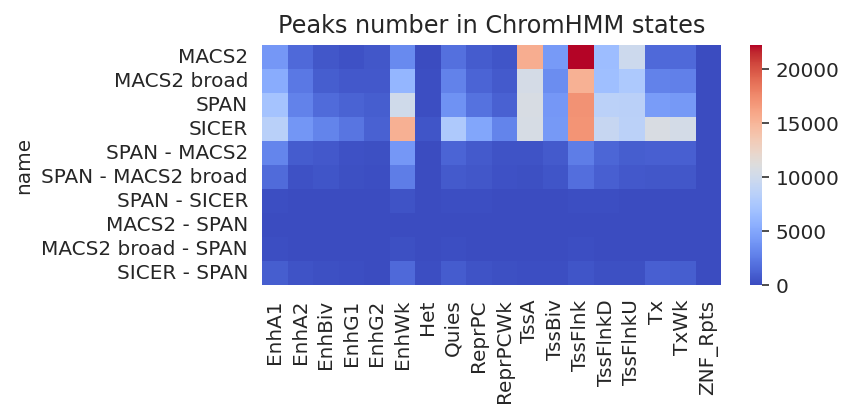

In [63]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_df_mean, cmap='coolwarm')
plt.title('Peaks number in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_chromhmm.pdf', bbox_inches='tight', dpi=300)
plt.show()

In [64]:
chromhmm_rel_df = chromhmm_df[['name']].copy()
for state in CHROMM_STATES:
    chromhmm_rel_df[state] = [d(ov, p) for ov, p in zip(chromhmm_df[state], chromhmm_df['peaks'])]
chromhmm_rel_df_mean = chromhmm_rel_df[['name'] + CHROMM_STATES].groupby('name').mean()
chromhmm_rel_df_mean = chromhmm_rel_df_mean.loc[['MACS2', 'MACS2 broad', 'SPAN', 'SICER',
                                                 'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                                 'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                                 ]]
chromhmm_rel_df_mean

EnhA1     EnhA2    EnhBiv     EnhG1     EnhG2  \
name                                                                   
MACS2               0.109598  0.041580  0.017722  0.007435  0.016345   
MACS2 broad         0.203359  0.085545  0.039375  0.023797  0.026957   
SPAN                0.230033  0.090343  0.054961  0.037051  0.030515   
SICER               0.280957  0.132131  0.107683  0.072206  0.036303   
SPAN - MACS2        0.294337  0.081510  0.062289  0.027998  0.022817   
SPAN - MACS2 broad  0.274390  0.065880  0.058228  0.029841  0.021419   
SPAN - SICER        0.153588  0.029187  0.040524  0.020154  0.016375   
MACS2 - SPAN        0.065573  0.029774  0.026757  0.010721  0.005892   
MACS2 broad - SPAN  0.118075  0.052531  0.031879  0.017626  0.006537   
SICER - SPAN        0.300556  0.127624  0.089628  0.058346  0.026274   

                       EnhWk       Het     Quies    ReprPC  ReprPCWk  \
name                                                                   
MACS2               0.089352  0.001245  0.052727  0.022995  0.012355   
MACS2 broad         0.232027  0.003975  0.110225  0.050925  0.027832   
SPAN                0.319860  0.005133  0.122845  0.062892  0.035129   
SICER               0.516466  0.016873  0.262012  0.174051  0.098331   
SPAN - MACS2        0.352376  0.005856  0.119188  0.058719  0.031303   
SPAN - MACS2 broad  0.358476  0.005577  0.117263  0.055783  0.030991   
SPAN - SICER        0.299655  0.008271  0.147223  0.067823  0.044384   
MACS2 - SPAN        0.215277  0.023965  0.153291  0.064241  0.040521   
MACS2 broad - SPAN  0.242435  0.013034  0.188703  0.063737  0.039014   
SICER - SPAN        0.533697  0.030256  0.258712  0.141409  0.089306   

                        TssA    TssBiv   TssFlnk  TssFlnkD  TssFlnkU  \
name                                                                   
MACS2               0.473607  0.136173  0.664923  0.192980  0.284546   
MACS2 broad         0.456487  0.162301  0.658542  0.284020  0.315957   
SPAN                0.380761  0.159446  0.601147  0.293494  0.292581   
SICER               0.371408  0.154621  0.592524  0.324536  0.295248   
SPAN - MACS2        0.055089  0.121073  0.279965  0.129269  0.111252   
SPAN - MACS2 broad  0.042024  0.096579  0.250036  0.122865  0.092476   
SPAN - SICER        0.017872  0.024822  0.162292  0.090669  0.044320   
MACS2 - SPAN        0.025375  0.063441  0.131046  0.051228  0.030077   
MACS2 broad - SPAN  0.018510  0.052945  0.099439  0.041193  0.029459   
SICER - SPAN        0.029866  0.045673  0.164828  0.085033  0.067674   

                          Tx      TxWk  ZNF_Rpts  
name                                              
MACS2               0.041556  0.040876       0.0  
MACS2 broad         0.108407  0.105390       0.0  
SPAN                0.138835  0.133788       0.0  
SICER               0.364740  0.348778       0.0  
SPAN - MACS2        0.093679  0.088089       0.0  
SPAN - MACS2 broad  0.095221  0.088581       0.0  
SPAN - SICER        0.068719  0.063354       0.0  
MACS2 - SPAN        0.041642  0.040952       0.0  
MACS2 broad - SPAN  0.074326  0.068495       0.0  
SICER - SPAN        0.317255  0.298067       0.0

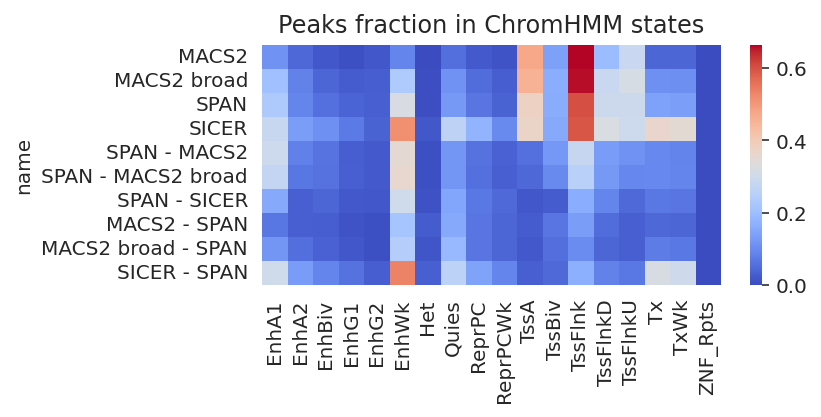

In [65]:
plt.figure(figsize=(6, 3))
sns.heatmap(chromhmm_rel_df_mean, cmap='coolwarm')
plt.title('Peaks fraction in ChromHMM states')
plt.tight_layout()
plt.savefig(f'{GSE26320_PATH_HG38}/pics/H3K4me3_chromhmm_rel.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Split by ChromHMM state and lengths distributions

In [66]:
tf = tempfile.mktemp()
BED_CHROMHMM = GSE26320_PATH_HG38 + '/bed_chromhmm'
!mkdir -p {BED_CHROMHMM}

print('Load lengths')
ts = []
for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    if c not in CHROMHMM_MAP:
        continue
    chromhmm = CHROMHMM_MAP[c]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        print(tool)
        peaks_file = sorted_file(t['file'].values[0])
        for state in CHROMM_STATES:
            state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
            path = f"{BED_CHROMHMM}/{c}_{r}_{tool}_{state}.bed".replace(' ', '_')
            !bedtools intersect -a {peaks_file} -b {state_file} -wa -u > {path}
            print(path)
            lengths = bedl(path)
            t = pd.DataFrame(dict(length=lengths))
            t = t.sample(min(len(t), 10_000))
            t['state'] = state
            t['name'] = tool
            ts.append(t)

        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K4me3') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            print(name)
            diff = f"{BED_CHROMHMM}/{c}_{r}_{name}.bed".replace(' ', '_').replace('_-_', '_')
            !bedtools intersect {args} -wa -v > {diff}
            for state in CHROMM_STATES:
                state_file = sorted_file(chromhmm.replace('.bed', f'_{state}.bed'))
                path = f"{BED_CHROMHMM}/{c}_{r}_{name}_{state}.bed".replace(' ', '_').replace('_-_', '_')
                !bedtools intersect -a {diff} -b {state_file} -wa -u > {path}
                print(path)
                lengths = bedl(path)
                t = pd.DataFrame(dict(length=lengths))
                t = t.sample(min(len(t), 10_000))
                t['state'] = state
                t['name'] = name
                ts.append(t)

t = pd.concat(ts).reset_index(drop=True)
del ts
t.sample(10)

Load lengths


0it [00:00, ?it/s]

GM12878 rep1
SICER
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_EnhA1.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_EnhA2.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_EnhBiv.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_EnhG1.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_EnhG2.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_EnhWk.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_Het.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_Quies.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_ReprPC.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_ReprPCWk.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_TssA.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM12878_rep1_SICER_TssBiv.bed
/home/jetbrains/data/2023_GSE26320/bed_chromhmm/GM1287

length     state   name
1330608  1028.0     EnhA1   SPAN
1670353  2540.0      TssA   SPAN
2181459   854.0    ReprPC   SPAN
1028366  2289.0  TssFlnkU   SPAN
2047691  2399.0    ReprPC  SICER
810782   2399.0     EnhWk  SICER
1907391  1652.0      TssA   SPAN
52073    2599.0      TssA  SICER
37118    2599.0     Quies  SICER
606619    342.0     EnhWk   SPAN

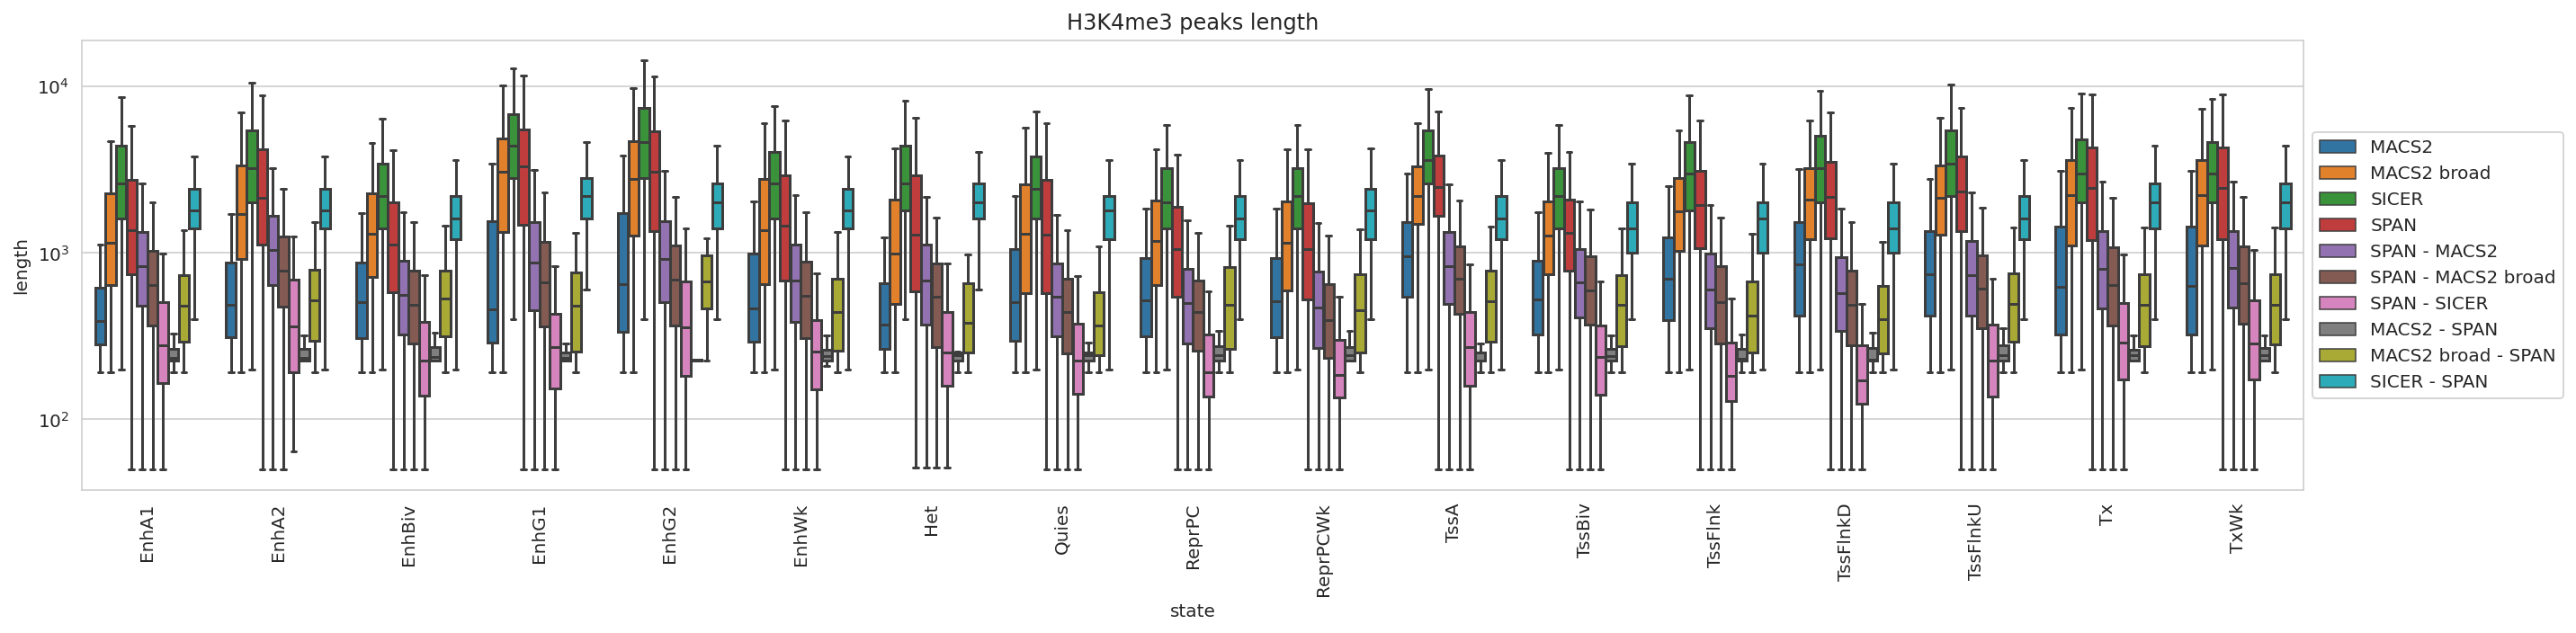

In [67]:
plt.figure(figsize=(20, 5))
ax = plt.axes()
g_results = sns.boxplot(data=t, x='state', y='length', hue='name', ax=ax,  showfliers=False,
                        hue_order=['MACS2', 'MACS2 broad', 'SICER', 'SPAN',
                                   'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                                   'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                                   ])
ax.title.set_text('H3K4me3 peaks length')
ax.xaxis.set_tick_params(rotation=90)
g_results.set(yscale='log')
# ax.set_ylim([0, 15_000])
# Put a legend to the right of the current axis
g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()